In [1]:
# Import libraries
import os
import sys
import requests
import sqlalchemy
from sqlalchemy.sql import text

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from utils.database import get_db
import utils.models as models

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

# Create connection to Database and extraction of required data

In [2]:
# create connection to the database
db = get_db()

In [3]:
# Define requested ticker ID:
ticker_id = 54

In [4]:
# set the presentation format of float numbers within the dataframe

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Fetch "daily multipliers" table from database

In [5]:
query = db.query(models.FullDailyMultipliers)
df_daily_multipliers = pd.read_sql(query.statement, query.session.bind)
df_daily_multipliers.head()
# len(df_daily_multipliers.index)
df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
73,74,2013-03-31,1,NaN,NaN,NaN,NaN,13.372
138,139,2013-06-30,1,NaN,NaN,NaN,NaN,4.769
1023,1024,2016-12-31,1,NaN,NaN,NaN,NaN,1.616
1212,1213,2017-09-30,1,NaN,NaN,NaN,NaN,2.706
1276,1277,2017-12-31,1,NaN,NaN,NaN,NaN,-0.474
...,...,...,...,...,...,...,...,...
1214116,1214117,2018-03-31,503,NaN,NaN,NaN,NaN,0.954
1214181,1214182,2018-06-30,503,NaN,NaN,NaN,NaN,0.738
1214245,1214246,2018-09-30,503,NaN,NaN,NaN,NaN,2.227
1214370,1214371,2019-03-31,503,NaN,NaN,NaN,NaN,-3.510


In [6]:
# Choose the stock_id we want to check (ticker_id)
daily_multipliers = df_daily_multipliers.loc[df_daily_multipliers['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
daily_multipliers = daily_multipliers.query('"2013-01-01" < date').copy().reset_index(drop=True)


daily_multipliers.head()
# df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
0,129029,2013-01-02,54,3227900000.000,5890700000.000,14.138,1.332,0.757
1,129030,2013-01-03,54,3211660000.000,5874460000.000,14.067,1.325,0.754
2,129031,2013-01-04,54,3243240000.000,5906040000.000,14.206,1.338,0.761
3,129032,2013-01-07,54,3168340000.000,5831140000.000,13.877,1.307,0.743
4,129033,2013-01-08,54,3174660000.000,5837460000.000,13.905,1.310,0.745


### Fetch "end of day prices" table from database

In [7]:

query = db.query(models.EndOfDayPrices)
df_end_of_day_prices = pd.read_sql(query.statement, query.session.bind)
df_end_of_day_prices.head()

# len(df_end_of_day_prices.head().index)


,id,stock_id,date,close_price
0,1,1,2012-01-03,83.490
1,2,1,2012-01-04,84.180
2,3,1,2012-01-05,83.800
3,4,1,2012-01-06,83.370
4,5,1,2012-01-09,83.870


### Select specific stock from end of day prices table (Apple Stock)

In [8]:
# Choose the stock_id we want to check (ticker_id)
end_of_day_prices = df_end_of_day_prices.loc[df_end_of_day_prices['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
end_of_day_prices = end_of_day_prices.query('"2013-01-01" < date').copy().reset_index(drop=True)


end_of_day_prices.head()
end_of_day_prices[end_of_day_prices.isna().any(axis=1)]

,id,stock_id,date,close_price


### Fetch "pfree cash flow multiplier" table from database

In [9]:
# fetch the end of day prices table from database

query = db.query(models.PFreeCashFlowMultiplier)
df_pfree_cash_flow = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
pfree_cash_flow = df_pfree_cash_flow.loc[df_pfree_cash_flow['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
pfree_cash_flow = pfree_cash_flow.query('"2013-01-01" < date').copy().reset_index(drop=True)


pfree_cash_flow.shape
pfree_cash_flow[pfree_cash_flow.isna().any(axis=1)]


,id,stock_id,date,year,quarter,pfree_cash_flow_ratio


### Fetch "graham number" table from database

In [10]:
# fetch the end of day prices table from database

query = db.query(models.GrahamNumber)
df_graham_number = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
graham_number = df_graham_number.loc[df_graham_number['stock_id'] == ticker_id]

# filter year =< 2012
graham_number = graham_number.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
graham_number.shape

graham_number[graham_number.isna().any(axis=1)]


,id,stock_id,year,quarter,graham_value


### Fetch "overview data" table from database

In [11]:
# fetch the overview data table from database

overview = models.QuarterlyOverview
query = db.query(overview.stock_id, overview.year, overview.quarter, overview.currentRatio )
df_overview_data = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
overview_data = df_overview_data.loc[df_overview_data['stock_id'] == ticker_id]

# filter year =< 2012
overview_data = overview_data.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
# overview_data.shape

overview_data

overview_data[overview_data.isna().any(axis=1)]

,stock_id,year,quarter,currentRatio
1,54,2022,0,NaN
6,54,2021,0,NaN
11,54,2020,0,NaN
16,54,2019,0,NaN
21,54,2018,0,NaN
26,54,2017,0,NaN
31,54,2016,0,NaN
36,54,2015,0,NaN
41,54,2014,0,NaN
46,54,2013,0,NaN


# Preprocessing of the data

# Join all five dataframes

In [12]:
# First, combine the two dataframes: "end of day prices" and "daily multipliers" into one joined dataframe (using outer join to maintain all rows)
joined_dataframe = pd.merge(end_of_day_prices, daily_multipliers, on='date', how='inner')

# Create 2 new columns for "date_plus_3m" & "market_cap_plus_3m"
day_gap = 60
date_plus_3m = joined_dataframe.loc[day_gap:,'date'].values
market_cap_plus_3m = joined_dataframe.loc[day_gap:,'market_cap'].values


joined_dataframe.drop(joined_dataframe.tail(day_gap).index, inplace = True)
joined_dataframe['date_plus_3m'] = date_plus_3m
joined_dataframe['market_cap_plus_3m'] = market_cap_plus_3m

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices = joined_dataframe

multiplier_with_closing_prices

# Check for Nan values in joined dataframe
multiplier_with_closing_prices[multiplier_with_closing_prices.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m


In [13]:
# Second, join the two dataframes: "multiplier_with_closing_prices" and "pfree_cash_flow" into one joined dataframe (using outer join to maintain all rows)

joined_dataframe = pd.merge(multiplier_with_closing_prices, pfree_cash_flow, on='date', how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Convert "date" column's type from object to datetime and "stock id" to int
joined_dataframe['date'] = pd.to_datetime(joined_dataframe['date'])
joined_dataframe['stock_id'] = joined_dataframe['stock_id'].astype('int')

# Handle Nan values that were formed due to the left join of the two dataframes
joined_dataframe["pfree_cash_flow_ratio"] = joined_dataframe["pfree_cash_flow_ratio"].interpolate(axis=0, limit_area='inside', limit=5)

joined_dataframe["year"] = joined_dataframe["date"].dt.year
joined_dataframe['quarter'] = joined_dataframe['date'].dt.quarter

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices_and_cash_flow = joined_dataframe

# multiplier_with_closing_prices_and_cash_flow

# multiplier_with_closing_prices_and_cash_flow.head()
multiplier_with_closing_prices_and_cash_flow[multiplier_with_closing_prices_and_cash_flow.isna().any(axis=1)]



,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio


In [14]:
# Next, merge the dataframe - "graham number", which has quarterly data with the previously joined dataframe,

joined_dataframe = pd.merge(multiplier_with_closing_prices_and_cash_flow, graham_number, on=['year', 'quarter'], how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
four_joined_dataframes = joined_dataframe

# four_joined_dataframes.head()

four_joined_dataframes[four_joined_dataframes.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value


In [15]:
# Finally, merge the remaining dataframe - "overview", which has quarterly data with the previously joined dataframe,


joined_dataframe = pd.merge(four_joined_dataframes, overview_data, on=['stock_id', 'year', 'quarter'], how='left')

# Rename dataframe for clarity purposes
final_joined_dataframe = joined_dataframe

# final_joined_dataframe.head()
final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

# final_joined_dataframe

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio


In [16]:
# create a new column - "diff_in_market_cap_perc" where:
# 1. calculates the change in market cap value 3 months apart and presents the difference in percentage

col1 = final_joined_dataframe['market_cap']
col2 = final_joined_dataframe['market_cap_plus_3m']

final_joined_dataframe['diff_in_mc'] = col2.sub(col1, axis=0)
final_joined_dataframe['diff_in_mc_perc'] = ((col2.sub(col1, axis=0)).div(col1)).mul(100)

# final_joined_dataframe.shape
final_joined_dataframe.head(200)

# final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc
0,0,54,2013-01-02,35.770,3227900000.000,5890700000.000,14.138,1.332,0.757,2013-04-01,3827080000.000,2013,1,-13.919,39.945,0.708,599180000.000,18.563
1,1,54,2013-01-03,35.590,3211660000.000,5874460000.000,14.067,1.325,0.754,2013-04-02,3827080000.000,2013,1,-13.849,39.945,0.708,615420000.000,19.162
2,2,54,2013-01-04,35.940,3243240000.000,5906040000.000,14.206,1.338,0.761,2013-04-03,3768240000.000,2013,1,-13.985,39.945,0.708,525000000.000,16.188
3,3,54,2013-01-07,35.110,3168340000.000,5831140000.000,13.877,1.307,0.743,2013-04-04,3801740000.000,2013,1,-13.662,39.945,0.708,633400000.000,19.992
4,4,54,2013-01-08,35.180,3174660000.000,5837460000.000,13.905,1.310,0.745,2013-04-05,3812600000.000,2013,1,-13.689,39.945,0.708,637940000.000,20.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,54,2013-10-10,41.910,3798730000.000,6556190000.000,15.638,1.472,-0.782,2014-01-07,4107420000.000,2013,4,-16.381,41.122,0.692,308690000.000,8.126
196,196,54,2013-10-11,42.320,3835890000.000,6593350000.000,15.791,1.487,-0.790,2014-01-08,4129230000.000,2013,4,-16.541,41.122,0.692,293340000.000,7.647
197,197,54,2013-10-14,42.220,3826830000.000,6584290000.000,15.754,1.483,-0.788,2014-01-09,4150140000.000,2013,4,-16.502,41.122,0.692,323310000.000,8.449
198,198,54,2013-10-15,41.210,3735280000.000,6492740000.000,15.377,1.448,-0.769,2014-01-10,4164690000.000,2013,4,-16.107,41.122,0.692,429410000.000,11.496


# 1. Optimizing the random forest model

In [17]:
# Define requested model and label thresholds:

label_threshold_lst = [1, 5, 10, 15, 20]

model_threshold_lst = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [18]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'
final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# Split the data to 60% train, 20% validation, 20% test
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


# Set the x (=features)
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']

# Split X to train and test
X_train, X_validation = train[X_Cols], validation[X_Cols]


In [19]:
train.shape

(1069, 18)

In [20]:
validation.shape

(357, 18)

In [21]:
test.shape

(357, 18)

In [22]:
# Model optimization using ParameterGrid() - ~percentage~ of profit

profit_with_params_dict = {}
# y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves

rf_clf_full_params = {
                'n_estimators':[51,101,151], # The number of trees in the forest
                'criterion':["gini", "entropy"], # The function to measure the quality of a split.
                'max_depth':[5, 7, 9, 11],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                'max_features':[3, 5, 7, 8], # The number of features to consider when looking for the best split results
                'random_state':[711]
                 }


# classifier = RandomForestClassifier
params = rf_clf_full_params
all_rf_params_permutations = list(ParameterGrid(params))
# print(len(list(ParameterGrid(params))))
# print(list(ParameterGrid(params)))

# Loop through different model parameters in order to find the optimized set of parameters for the requested stock, testing on a validation set:
for label_thresh in tqdm(label_threshold_lst, desc="label threshold"):
    # final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)    # create the label column  according to the first two parameters - label and model threshold
    train['label'] = (train["diff_in_mc_perc"] > label_thresh).astype(int)
    validation['label'] = (validation["diff_in_mc_perc"] > label_thresh).astype(int)
    Y_Cols = ['label']
    y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()  # this changes according to the tested label threshold, therefor inserted into the for loop
    for model_thresh in tqdm(model_threshold_lst, desc="model threshold"):
        for params in tqdm(all_rf_params_permutations, desc="model params"):
            rand_frst_clf = RandomForestClassifier(**params)  # run through the different classifier's parameters options
            rand_frst_clf.fit(X_train, y_train)   # fit (train) the data to the model
            y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1] # Make predictions (validation)
            y_pred = y_pred_proba > model_thresh
            validation['prediction'] = y_pred.astype(int)
            validation['profit_percentage'] = validation['diff_in_mc_perc'] * validation['prediction']
            profit_perc_sum = round(validation['profit_percentage'].sum(), 3)
            profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
            print('profit_perc_sum', profit_perc_sum, 'profit_perc_mean', profit_perc_mean, 'denominator', validation[validation['prediction']==1].shape[0])
            profit_with_params_dict[profit_perc_mean] = [label_thresh, model_thresh, params]

profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
max_profit_perc_in_sorted_dict = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:5]}

print(max_profit_perc_in_sorted_dict)

model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:11,  8.47it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:19,  4.73it/s]

profit_perc_sum 243.526 profit_perc_mean 6.409 denominator 38




model params:   3%|▎         | 3/96 [00:00<00:29,  3.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   4%|▍         | 4/96 [00:01<00:26,  3.42it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   5%|▌         | 5/96 [00:01<00:30,  2.98it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:02<00:36,  2.45it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:   7%|▋         | 7/96 [00:02<00:30,  2.90it/s]

model params:   8%|▊         | 8/96 [00:02<00:34,  2.54it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:41,  2.12it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  10%|█         | 10/96 [00:03<00:33,  2.54it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  11%|█▏        | 11/96 [00:04<00:34,  2.48it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  12%|█▎        | 12/96 [00:04<00:39,  2.15it/s]

model params:  14%|█▎        | 13/96 [00:04<00:30,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:05<00:29,  2.82it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:05<00:32,  2.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:05<00:28,  2.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  18%|█▊        | 17/96 [00:06<00:30,  2.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:06<00:36,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:07<00:31,  2.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  21%|██        | 20/96 [00:07<00:33,  2.26it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  23%|██▎       | 22/96 [00:08<00:34,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  24%|██▍       | 23/96 [00:09<00:35,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  25%|██▌       | 24/96 [00:10<00:41,  1.74it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  27%|██▋       | 26/96 [00:10<00:28,  2.43it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:11<00:29,  2.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:11<00:25,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  30%|███       | 29/96 [00:11<00:26,  2.55it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:12<00:30,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:12<00:26,  2.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  33%|███▎      | 32/96 [00:13<00:28,  2.26it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:14<00:34,  1.81it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  35%|███▌      | 34/96 [00:14<00:29,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  36%|███▋      | 35/96 [00:14<00:30,  2.02it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:15<00:35,  1.69it/s]

model params:  39%|███▊      | 37/96 [00:15<00:27,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 119.803 profit_perc_mean 7.047 denominator 17




model params:  40%|███▉      | 38/96 [00:16<00:24,  2.37it/s]

profit_perc_sum 119.803 profit_perc_mean 7.047 denominator 17




model params:  41%|████      | 39/96 [00:16<00:25,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:16<00:20,  2.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  43%|████▎     | 41/96 [00:17<00:21,  2.51it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:18<00:28,  1.88it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:18<00:26,  2.03it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  46%|████▌     | 44/96 [00:19<00:31,  1.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:20<00:37,  1.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:20<00:30,  1.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  49%|████▉     | 47/96 [00:21<00:29,  1.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:22<00:31,  1.51it/s]

model params:  51%|█████     | 49/96 [00:22<00:23,  1.98it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 8.416 profit_perc_mean 1.403 denominator 6




model params:  52%|█████▏    | 50/96 [00:22<00:20,  2.25it/s]

profit_perc_sum 281.105 profit_perc_mean 5.304 denominator 53




model params:  53%|█████▎    | 51/96 [00:23<00:20,  2.24it/s]



profit_perc_sum 46.335 profit_perc_mean 2.015 denominator 23
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  54%|█████▍    | 52/96 [00:23<00:16,  2.66it/s]

model params:  55%|█████▌    | 53/96 [00:23<00:16,  2.58it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  56%|█████▋    | 54/96 [00:24<00:19,  2.19it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:24<00:16,  2.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  58%|█████▊    | 56/96 [00:25<00:17,  2.25it/s]

profit_perc_sum 272.431 profit_perc_mean 5.56 denominator 49




model params:  59%|█████▉    | 57/96 [00:25<00:21,  1.85it/s]

profit_perc_sum 272.431 profit_perc_mean 5.56 denominator 49




model params:  60%|██████    | 58/96 [00:26<00:17,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  61%|██████▏   | 59/96 [00:26<00:17,  2.08it/s]

profit_perc_sum 272.431 profit_perc_mean 5.56 denominator 49




model params:  62%|██████▎   | 60/96 [00:27<00:20,  1.76it/s]

model params:  64%|██████▎   | 61/96 [00:27<00:15,  2.22it/s]

profit_perc_sum 272.431 profit_perc_mean 5.56 denominator 49
profit_perc_sum 8.975 profit_perc_mean 0.997 denominator 9




model params:  65%|██████▍   | 62/96 [00:27<00:14,  2.37it/s]

profit_perc_sum 9.217 profit_perc_mean 1.152 denominator 8




model params:  66%|██████▌   | 63/96 [00:28<00:14,  2.21it/s]

profit_perc_sum 9.217 profit_perc_mean 1.152 denominator 8




model params:  67%|██████▋   | 64/96 [00:28<00:12,  2.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.37it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:29<00:15,  1.94it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.21it/s]

profit_perc_sum 243.526 profit_perc_mean 6.409 denominator 38




model params:  71%|███████   | 68/96 [00:30<00:14,  1.98it/s]

profit_perc_sum 227.982 profit_perc_mean 6.333 denominator 36




model params:  72%|███████▏  | 69/96 [00:31<00:16,  1.61it/s]

profit_perc_sum 243.526 profit_perc_mean 6.409 denominator 38




model params:  73%|███████▎  | 70/96 [00:32<00:13,  1.91it/s]

profit_perc_sum 243.526 profit_perc_mean 6.409 denominator 38




model params:  74%|███████▍  | 71/96 [00:32<00:14,  1.78it/s]

profit_perc_sum 227.982 profit_perc_mean 6.333 denominator 36




model params:  75%|███████▌  | 72/96 [00:33<00:15,  1.51it/s]



profit_perc_sum 243.526 profit_perc_mean 6.409 denominator 38
profit_perc_sum 7.253 profit_perc_mean 3.626 denominator 2


model params:  76%|███████▌  | 73/96 [00:33<00:11,  1.93it/s]

model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.12it/s]

profit_perc_sum 7.253 profit_perc_mean 3.626 denominator 2




model params:  78%|███████▊  | 75/96 [00:34<00:10,  2.03it/s]

profit_perc_sum 26.837 profit_perc_mean 2.982 denominator 9




model params:  79%|███████▉  | 76/96 [00:34<00:08,  2.37it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  80%|████████  | 77/96 [00:35<00:08,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:36<00:09,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:36<00:08,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  83%|████████▎ | 80/96 [00:37<00:08,  1.90it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  84%|████████▍ | 81/96 [00:38<00:09,  1.53it/s]

profit_perc_sum 220.61 profit_perc_mean 6.303 denominator 35




model params:  85%|████████▌ | 82/96 [00:38<00:07,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  86%|████████▋ | 83/96 [00:39<00:07,  1.70it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  88%|████████▊ | 84/96 [00:40<00:08,  1.37it/s]

profit_perc_sum 220.61 profit_perc_mean 6.303 denominator 35
profit_perc_sum 240.121 profit_perc_mean 6.157 denominator 39




model params:  89%|████████▊ | 85/96 [00:40<00:06,  1.74it/s]

model params:  90%|████████▉ | 86/96 [00:40<00:05,  1.91it/s]

profit_perc_sum 229.425 profit_perc_mean 6.201 denominator 37




model params:  91%|█████████ | 87/96 [00:41<00:04,  1.84it/s]

profit_perc_sum 112.332 profit_perc_mean 5.106 denominator 22




model params:  92%|█████████▏| 88/96 [00:41<00:03,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  93%|█████████▎| 89/96 [00:42<00:03,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:43<00:03,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:43<00:02,  2.00it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:44<00:02,  1.83it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  97%|█████████▋| 93/96 [00:45<00:02,  1.48it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  98%|█████████▊| 94/96 [00:45<00:01,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:46<00:00,  1.67it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params: 100%|██████████| 96/96 [00:46<00:00,  2.04it/s]

model threshold:  17%|█▋        | 1/6 [00:46<03:54, 46.97s/it]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.41it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:20,  4.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:28,  3.26it/s]

model params:   4%|▍         | 4/96 [00:00<00:23,  3.92it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   5%|▌         | 5/96 [00:01<00:26,  3.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:01<00:33,  2.72it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   7%|▋         | 7/96 [00:02<00:28,  3.11it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   8%|▊         | 8/96 [00:02<00:31,  2.78it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:38,  2.24it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  10%|█         | 10/96 [00:03<00:32,  2.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  11%|█▏        | 11/96 [00:03<00:33,  2.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  12%|█▎        | 12/96 [00:04<00:38,  2.17it/s]

model params:  14%|█▎        | 13/96 [00:04<00:31,  2.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:05<00:31,  2.58it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:05<00:37,  2.15it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:05<00:33,  2.41it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  18%|█▊        | 17/96 [00:06<00:38,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:07<00:46,  1.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:07<00:38,  1.98it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  21%|██        | 20/96 [00:08<00:38,  1.96it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  22%|██▏       | 21/96 [00:09<00:43,  1.71it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  23%|██▎       | 22/96 [00:09<00:35,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  24%|██▍       | 23/96 [00:09<00:35,  2.03it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  25%|██▌       | 24/96 [00:10<00:40,  1.77it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  27%|██▋       | 26/96 [00:11<00:29,  2.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:11<00:30,  2.26it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:11<00:25,  2.66it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  30%|███       | 29/96 [00:12<00:26,  2.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:12<00:31,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:13<00:27,  2.40it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  33%|███▎      | 32/96 [00:13<00:29,  2.19it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:14<00:35,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  35%|███▌      | 34/96 [00:14<00:29,  2.09it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  36%|███▋      | 35/96 [00:15<00:30,  2.00it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:16<00:35,  1.70it/s]

model params:  39%|███▊      | 37/96 [00:16<00:27,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  40%|███▉      | 38/96 [00:16<00:24,  2.37it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  41%|████      | 39/96 [00:17<00:25,  2.25it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:17<00:21,  2.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  43%|████▎     | 41/96 [00:17<00:22,  2.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:18<00:26,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:18<00:22,  2.34it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  46%|████▌     | 44/96 [00:19<00:24,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:20<00:29,  1.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:20<00:24,  2.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  49%|████▉     | 47/96 [00:21<00:25,  1.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:21<00:30,  1.59it/s]

model params:  51%|█████     | 49/96 [00:22<00:22,  2.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 7.253 profit_perc_mean 3.626 denominator 2




model params:  52%|█████▏    | 50/96 [00:22<00:20,  2.27it/s]

profit_perc_sum 14.125 profit_perc_mean 3.531 denominator 4




model params:  53%|█████▎    | 51/96 [00:22<00:20,  2.23it/s]

profit_perc_sum 19.419 profit_perc_mean 3.236 denominator 6




model params:  54%|█████▍    | 52/96 [00:23<00:16,  2.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  55%|█████▌    | 53/96 [00:23<00:16,  2.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  56%|█████▋    | 54/96 [00:24<00:19,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:24<00:17,  2.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  58%|█████▊    | 56/96 [00:25<00:19,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  59%|█████▉    | 57/96 [00:26<00:22,  1.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  60%|██████    | 58/96 [00:26<00:19,  1.99it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  61%|██████▏   | 59/96 [00:26<00:19,  1.92it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  62%|██████▎   | 60/96 [00:27<00:21,  1.65it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 7.253 profit_perc_mean 3.626 denominator 2


model params:  64%|██████▎   | 61/96 [00:27<00:16,  2.07it/s]

model params:  65%|██████▍   | 62/96 [00:28<00:15,  2.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  66%|██████▌   | 63/96 [00:28<00:15,  2.08it/s]

profit_perc_sum 7.253 profit_perc_mean 3.626 denominator 2




model params:  67%|██████▋   | 64/96 [00:29<00:13,  2.40it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:30<00:15,  1.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.18it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  71%|███████   | 68/96 [00:31<00:14,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  72%|███████▏  | 69/96 [00:32<00:16,  1.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  73%|███████▎  | 70/96 [00:32<00:13,  1.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  74%|███████▍  | 71/96 [00:33<00:13,  1.81it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  75%|███████▌  | 72/96 [00:33<00:15,  1.54it/s]

model params:  76%|███████▌  | 73/96 [00:34<00:11,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:35<00:10,  2.02it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.36it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  80%|████████  | 77/96 [00:35<00:08,  2.19it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:36<00:11,  1.59it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:37<00:09,  1.73it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  83%|████████▎ | 80/96 [00:38<00:10,  1.47it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  84%|████████▍ | 81/96 [00:39<00:11,  1.25it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  85%|████████▌ | 82/96 [00:39<00:09,  1.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  86%|████████▋ | 83/96 [00:40<00:08,  1.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  88%|████████▊ | 84/96 [00:41<00:08,  1.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  89%|████████▊ | 85/96 [00:41<00:06,  1.74it/s]

profit_perc_sum 16.48 profit_perc_mean 5.493 denominator 3




model params:  90%|████████▉ | 86/96 [00:41<00:05,  1.94it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  91%|█████████ | 87/96 [00:42<00:04,  1.86it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  92%|█████████▏| 88/96 [00:42<00:03,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  93%|█████████▎| 89/96 [00:43<00:03,  1.98it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:44<00:03,  1.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:44<00:02,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.54it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.26it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  98%|█████████▊| 94/96 [00:46<00:01,  1.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.51it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params: 100%|██████████| 96/96 [00:48<00:00,  1.98it/s]

model threshold:  33%|███▎      | 2/6 [01:35<03:11, 47.88s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:19,  4.78it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:27,  3.34it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:   4%|▍         | 4/96 [00:00<00:23,  3.96it/s]

model params:   5%|▌         | 5/96 [00:01<00:26,  3.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:01<00:33,  2.66it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   7%|▋         | 7/96 [00:02<00:29,  3.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   8%|▊         | 8/96 [00:02<00:32,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:39,  2.21it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  10%|█         | 10/96 [00:03<00:32,  2.64it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  11%|█▏        | 11/96 [00:03<00:34,  2.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  12%|█▎        | 12/96 [00:04<00:40,  2.09it/s]

model params:  14%|█▎        | 13/96 [00:04<00:31,  2.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:05<00:29,  2.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:05<00:31,  2.54it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:05<00:26,  2.97it/s]

model params:  18%|█▊        | 17/96 [00:06<00:28,  2.78it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:06<00:34,  2.29it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:06<00:29,  2.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  21%|██        | 20/96 [00:07<00:32,  2.37it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  22%|██▏       | 21/96 [00:08<00:39,  1.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  23%|██▎       | 22/96 [00:08<00:32,  2.25it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  25%|██▌       | 24/96 [00:09<00:39,  1.81it/s]

model params:  26%|██▌       | 25/96 [00:09<00:31,  2.29it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  27%|██▋       | 26/96 [00:10<00:28,  2.48it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:10<00:29,  2.33it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:10<00:25,  2.69it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  30%|███       | 29/96 [00:11<00:26,  2.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:12<00:31,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:12<00:27,  2.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  33%|███▎      | 32/96 [00:12<00:29,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:13<00:36,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  35%|███▌      | 34/96 [00:14<00:30,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  36%|███▋      | 35/96 [00:14<00:31,  1.96it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:15<00:36,  1.66it/s]

model params:  39%|███▊      | 37/96 [00:15<00:27,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  40%|███▉      | 38/96 [00:15<00:24,  2.34it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  41%|████      | 39/96 [00:16<00:26,  2.15it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:16<00:23,  2.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  43%|████▎     | 41/96 [00:17<00:28,  1.96it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:18<00:35,  1.51it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:19<00:32,  1.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  46%|████▌     | 44/96 [00:19<00:32,  1.60it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:20<00:35,  1.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:20<00:28,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  49%|████▉     | 47/96 [00:21<00:27,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:22<00:30,  1.55it/s]

model params:  51%|█████     | 49/96 [00:22<00:23,  2.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  52%|█████▏    | 50/96 [00:22<00:20,  2.24it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  53%|█████▎    | 51/96 [00:23<00:20,  2.19it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  54%|█████▍    | 52/96 [00:23<00:16,  2.60it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  55%|█████▌    | 53/96 [00:23<00:17,  2.50it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  56%|█████▋    | 54/96 [00:24<00:19,  2.12it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:24<00:16,  2.44it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  58%|█████▊    | 56/96 [00:25<00:18,  2.21it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  59%|█████▉    | 57/96 [00:26<00:21,  1.81it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  60%|██████    | 58/96 [00:26<00:17,  2.15it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  61%|██████▏   | 59/96 [00:26<00:17,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  62%|██████▎   | 60/96 [00:27<00:20,  1.74it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  64%|██████▎   | 61/96 [00:27<00:15,  2.20it/s]

model params:  65%|██████▍   | 62/96 [00:28<00:14,  2.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  66%|██████▌   | 63/96 [00:28<00:15,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  67%|██████▋   | 64/96 [00:28<00:12,  2.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.30it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:30<00:16,  1.83it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  71%|███████   | 68/96 [00:31<00:14,  1.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  72%|███████▏  | 69/96 [00:32<00:17,  1.56it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  73%|███████▎  | 70/96 [00:32<00:14,  1.84it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  74%|███████▍  | 71/96 [00:33<00:14,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  75%|███████▌  | 72/96 [00:34<00:16,  1.47it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  76%|███████▌  | 73/96 [00:34<00:12,  1.87it/s]

model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:35<00:10,  1.96it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.30it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  80%|████████  | 77/96 [00:35<00:08,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:36<00:09,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:37<00:08,  2.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  83%|████████▎ | 80/96 [00:37<00:08,  1.84it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  84%|████████▍ | 81/96 [00:38<00:10,  1.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  85%|████████▌ | 82/96 [00:39<00:08,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  86%|████████▋ | 83/96 [00:39<00:07,  1.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  88%|████████▊ | 84/96 [00:40<00:08,  1.42it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  89%|████████▊ | 85/96 [00:40<00:06,  1.81it/s]

model params:  90%|████████▉ | 86/96 [00:41<00:05,  1.99it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  91%|█████████ | 87/96 [00:41<00:04,  1.90it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  92%|█████████▏| 88/96 [00:42<00:03,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  93%|█████████▎| 89/96 [00:42<00:03,  1.94it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:44<00:04,  1.37it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:44<00:03,  1.50it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:45<00:03,  1.28it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  98%|█████████▊| 94/96 [00:47<00:01,  1.28it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:48<00:00,  1.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params: 100%|██████████| 96/96 [00:49<00:00,  1.95it/s]

model threshold:  50%|█████     | 3/6 [02:24<02:25, 48.45s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:13,  6.99it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:20,  4.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:29,  3.14it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:   4%|▍         | 4/96 [00:01<00:24,  3.74it/s]

model params:   5%|▌         | 5/96 [00:01<00:27,  3.31it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:01<00:34,  2.63it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   7%|▋         | 7/96 [00:02<00:29,  3.00it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   8%|▊         | 8/96 [00:02<00:32,  2.73it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:40,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  10%|█         | 10/96 [00:03<00:33,  2.56it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  11%|█▏        | 11/96 [00:03<00:34,  2.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  12%|█▎        | 12/96 [00:04<00:39,  2.11it/s]

model params:  14%|█▎        | 13/96 [00:04<00:31,  2.63it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:05<00:29,  2.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:05<00:32,  2.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:05<00:28,  2.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  18%|█▊        | 17/96 [00:06<00:29,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:06<00:34,  2.24it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:07<00:31,  2.48it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  21%|██        | 20/96 [00:07<00:33,  2.26it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.87it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  25%|██▌       | 24/96 [00:09<00:40,  1.78it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  27%|██▋       | 26/96 [00:10<00:28,  2.46it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:10<00:29,  2.33it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:11<00:25,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  30%|███       | 29/96 [00:11<00:26,  2.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:12<00:31,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:12<00:27,  2.39it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  33%|███▎      | 32/96 [00:13<00:30,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:14<00:37,  1.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  35%|███▌      | 34/96 [00:14<00:31,  1.98it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  36%|███▋      | 35/96 [00:14<00:31,  1.92it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:15<00:36,  1.63it/s]

model params:  39%|███▊      | 37/96 [00:15<00:28,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  40%|███▉      | 38/96 [00:16<00:25,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  41%|████      | 39/96 [00:16<00:26,  2.18it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:16<00:21,  2.56it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  43%|████▎     | 41/96 [00:17<00:22,  2.42it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:18<00:27,  1.99it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:18<00:24,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  46%|████▌     | 44/96 [00:19<00:29,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:20<00:39,  1.28it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:20<00:32,  1.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  49%|████▉     | 47/96 [00:21<00:31,  1.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:22<00:33,  1.42it/s]

model params:  51%|█████     | 49/96 [00:22<00:25,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  52%|█████▏    | 50/96 [00:22<00:21,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  53%|█████▎    | 51/96 [00:23<00:21,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  54%|█████▍    | 52/96 [00:23<00:17,  2.50it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.42it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  56%|█████▋    | 54/96 [00:24<00:20,  2.09it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:24<00:17,  2.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  58%|█████▊    | 56/96 [00:25<00:18,  2.18it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  59%|█████▉    | 57/96 [00:26<00:21,  1.78it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  60%|██████    | 58/96 [00:26<00:18,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  61%|██████▏   | 59/96 [00:27<00:18,  2.03it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  62%|██████▎   | 60/96 [00:27<00:21,  1.71it/s]

model params:  64%|██████▎   | 61/96 [00:28<00:16,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  65%|██████▍   | 62/96 [00:28<00:14,  2.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  66%|██████▌   | 63/96 [00:29<00:15,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  67%|██████▋   | 64/96 [00:29<00:12,  2.46it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.29it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:30<00:16,  1.87it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  71%|███████   | 68/96 [00:31<00:14,  1.93it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  72%|███████▏  | 69/96 [00:32<00:17,  1.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  73%|███████▎  | 70/96 [00:32<00:14,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  74%|███████▍  | 71/96 [00:33<00:14,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  75%|███████▌  | 72/96 [00:34<00:16,  1.49it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  76%|███████▌  | 73/96 [00:34<00:12,  1.90it/s]

model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:35<00:10,  1.96it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.29it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  80%|████████  | 77/96 [00:36<00:08,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:37<00:10,  1.79it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:37<00:08,  2.04it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  83%|████████▎ | 80/96 [00:38<00:08,  1.84it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  84%|████████▍ | 81/96 [00:38<00:10,  1.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  85%|████████▌ | 82/96 [00:39<00:07,  1.76it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  86%|████████▋ | 83/96 [00:39<00:07,  1.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  88%|████████▊ | 84/96 [00:41<00:08,  1.36it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  89%|████████▊ | 85/96 [00:41<00:06,  1.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  90%|████████▉ | 86/96 [00:41<00:05,  1.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  91%|█████████ | 87/96 [00:42<00:05,  1.50it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  92%|█████████▏| 88/96 [00:43<00:04,  1.71it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  93%|█████████▎| 89/96 [00:43<00:04,  1.64it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:44<00:04,  1.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:44<00:02,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.66it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.39it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  98%|█████████▊| 94/96 [00:46<00:01,  1.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.59it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params: 100%|██████████| 96/96 [00:48<00:00,  1.97it/s]

model threshold:  67%|██████▋   | 4/6 [03:13<01:37, 48.52s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:20,  4.69it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:28,  3.31it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:   4%|▍         | 4/96 [00:00<00:23,  3.90it/s]

model params:   5%|▌         | 5/96 [00:01<00:27,  3.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:01<00:33,  2.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   7%|▋         | 7/96 [00:02<00:29,  3.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   8%|▊         | 8/96 [00:02<00:32,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:40,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  10%|█         | 10/96 [00:03<00:33,  2.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  11%|█▏        | 11/96 [00:03<00:35,  2.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  12%|█▎        | 12/96 [00:04<00:41,  2.04it/s]

model params:  14%|█▎        | 13/96 [00:04<00:32,  2.56it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:05<00:30,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:05<00:32,  2.51it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:05<00:27,  2.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  18%|█▊        | 17/96 [00:06<00:28,  2.74it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:06<00:34,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:07<00:29,  2.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  21%|██        | 20/96 [00:07<00:32,  2.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.87it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.19it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  25%|██▌       | 24/96 [00:09<00:40,  1.77it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  27%|██▋       | 26/96 [00:10<00:29,  2.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:11<00:31,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:11<00:27,  2.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  30%|███       | 29/96 [00:11<00:28,  2.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:12<00:36,  1.82it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:13<00:34,  1.88it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  33%|███▎      | 32/96 [00:14<00:41,  1.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:15<00:53,  1.18it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  35%|███▌      | 34/96 [00:15<00:44,  1.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  36%|███▋      | 35/96 [00:16<00:43,  1.39it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:17<00:45,  1.32it/s]

model params:  39%|███▊      | 37/96 [00:17<00:34,  1.71it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  40%|███▉      | 38/96 [00:17<00:29,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  41%|████      | 39/96 [00:18<00:28,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:18<00:23,  2.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  43%|████▎     | 41/96 [00:19<00:24,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:19<00:27,  1.94it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:20<00:23,  2.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  46%|████▌     | 44/96 [00:20<00:25,  2.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:21<00:30,  1.67it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:21<00:25,  1.98it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  49%|████▉     | 47/96 [00:22<00:25,  1.91it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:23<00:30,  1.59it/s]

model params:  51%|█████     | 49/96 [00:23<00:23,  2.04it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  52%|█████▏    | 50/96 [00:23<00:20,  2.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  53%|█████▎    | 51/96 [00:24<00:20,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.41it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  56%|█████▋    | 54/96 [00:25<00:20,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:25<00:17,  2.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  58%|█████▊    | 56/96 [00:26<00:18,  2.18it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  59%|█████▉    | 57/96 [00:27<00:22,  1.77it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  60%|██████    | 58/96 [00:27<00:18,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  61%|██████▏   | 59/96 [00:28<00:18,  2.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  62%|██████▎   | 60/96 [00:28<00:21,  1.69it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  64%|██████▎   | 61/96 [00:29<00:16,  2.12it/s]

model params:  65%|██████▍   | 62/96 [00:29<00:15,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  66%|██████▌   | 63/96 [00:29<00:15,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  67%|██████▋   | 64/96 [00:30<00:12,  2.47it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  68%|██████▊   | 65/96 [00:30<00:13,  2.30it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:31<00:15,  1.89it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:31<00:13,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  71%|███████   | 68/96 [00:32<00:14,  1.90it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  72%|███████▏  | 69/96 [00:33<00:20,  1.30it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  73%|███████▎  | 70/96 [00:34<00:17,  1.48it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  74%|███████▍  | 71/96 [00:35<00:18,  1.35it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  75%|███████▌  | 72/96 [00:36<00:19,  1.24it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  76%|███████▌  | 73/96 [00:36<00:14,  1.61it/s]

model params:  77%|███████▋  | 74/96 [00:36<00:12,  1.82it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:37<00:11,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  79%|███████▉  | 76/96 [00:37<00:09,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  80%|████████  | 77/96 [00:38<00:09,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:38<00:10,  1.75it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:39<00:08,  1.99it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  83%|████████▎ | 80/96 [00:39<00:08,  1.81it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  84%|████████▍ | 81/96 [00:40<00:10,  1.47it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  85%|████████▌ | 82/96 [00:41<00:08,  1.73it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  86%|████████▋ | 83/96 [00:41<00:07,  1.64it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  88%|████████▊ | 84/96 [00:42<00:08,  1.37it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  89%|████████▊ | 85/96 [00:43<00:06,  1.74it/s]

model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.92it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  91%|█████████ | 87/96 [00:44<00:04,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  92%|█████████▏| 88/96 [00:44<00:03,  2.18it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  93%|█████████▎| 89/96 [00:44<00:03,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:46<00:04,  1.43it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:46<00:03,  1.56it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:47<00:03,  1.30it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  97%|█████████▋| 93/96 [00:49<00:02,  1.02it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  98%|█████████▊| 94/96 [00:49<00:01,  1.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params: 100%|██████████| 96/96 [00:51<00:00,  1.86it/s]

model threshold:  83%|████████▎ | 5/6 [04:04<00:49, 49.63s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:15,  6.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:31,  2.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:01<00:47,  1.96it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   4%|▍         | 4/96 [00:01<00:39,  2.33it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   5%|▌         | 5/96 [00:02<00:43,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:02<00:52,  1.73it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   7%|▋         | 7/96 [00:03<00:44,  2.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   8%|▊         | 8/96 [00:03<00:44,  1.99it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   9%|▉         | 9/96 [00:04<00:48,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  10%|█         | 10/96 [00:04<00:39,  2.20it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  11%|█▏        | 11/96 [00:05<00:38,  2.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  12%|█▎        | 12/96 [00:05<00:43,  1.95it/s]

model params:  14%|█▎        | 13/96 [00:05<00:33,  2.46it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:06<00:31,  2.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:06<00:33,  2.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:07<00:28,  2.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  18%|█▊        | 17/96 [00:07<00:29,  2.69it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:08<00:34,  2.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:08<00:30,  2.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  21%|██        | 20/96 [00:08<00:33,  2.29it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  22%|██▏       | 21/96 [00:09<00:40,  1.84it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  23%|██▎       | 22/96 [00:09<00:34,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  24%|██▍       | 23/96 [00:10<00:35,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  25%|██▌       | 24/96 [00:11<00:41,  1.75it/s]

model params:  26%|██▌       | 25/96 [00:11<00:32,  2.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  27%|██▋       | 26/96 [00:11<00:29,  2.40it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:12<00:30,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:12<00:25,  2.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  30%|███       | 29/96 [00:12<00:26,  2.48it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:13<00:31,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:13<00:27,  2.33it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  33%|███▎      | 32/96 [00:14<00:30,  2.12it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:15<00:36,  1.72it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  35%|███▌      | 34/96 [00:15<00:30,  2.02it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  36%|███▋      | 35/96 [00:16<00:31,  1.93it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:17<00:36,  1.62it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  39%|███▊      | 37/96 [00:17<00:28,  2.06it/s]

model params:  40%|███▉      | 38/96 [00:17<00:25,  2.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  41%|████      | 39/96 [00:18<00:29,  1.92it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:18<00:26,  2.14it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  43%|████▎     | 41/96 [00:19<00:29,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:20<00:39,  1.36it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:20<00:33,  1.60it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  46%|████▌     | 44/96 [00:21<00:33,  1.56it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:22<00:37,  1.36it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:22<00:30,  1.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  49%|████▉     | 47/96 [00:23<00:30,  1.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:24<00:33,  1.43it/s]

model params:  51%|█████     | 49/96 [00:24<00:25,  1.84it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  52%|█████▏    | 50/96 [00:24<00:22,  2.03it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  53%|█████▎    | 51/96 [00:25<00:23,  1.95it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  54%|█████▍    | 52/96 [00:25<00:19,  2.28it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  55%|█████▌    | 53/96 [00:26<00:19,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  56%|█████▋    | 54/96 [00:27<00:23,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:27<00:19,  2.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  58%|█████▊    | 56/96 [00:27<00:20,  1.94it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  59%|█████▉    | 57/96 [00:28<00:24,  1.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  60%|██████    | 58/96 [00:29<00:19,  1.90it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  61%|██████▏   | 59/96 [00:29<00:19,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  62%|██████▎   | 60/96 [00:30<00:22,  1.60it/s]



profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  64%|██████▎   | 61/96 [00:30<00:17,  2.04it/s]

model params:  65%|██████▍   | 62/96 [00:31<00:15,  2.22it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  66%|██████▌   | 63/96 [00:31<00:15,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  67%|██████▋   | 64/96 [00:31<00:13,  2.42it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  68%|██████▊   | 65/96 [00:32<00:13,  2.25it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:33<00:16,  1.83it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:33<00:13,  2.07it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  71%|███████   | 68/96 [00:34<00:14,  1.90it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  72%|███████▏  | 69/96 [00:35<00:18,  1.46it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  73%|███████▎  | 70/96 [00:35<00:16,  1.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  74%|███████▍  | 71/96 [00:36<00:18,  1.38it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  75%|███████▌  | 72/96 [00:37<00:21,  1.12it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  76%|███████▌  | 73/96 [00:38<00:15,  1.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  77%|███████▋  | 74/96 [00:38<00:13,  1.66it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:39<00:12,  1.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  79%|███████▉  | 76/96 [00:39<00:09,  2.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  80%|████████  | 77/96 [00:39<00:09,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:40<00:10,  1.69it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:40<00:08,  1.95it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  83%|████████▎ | 80/96 [00:41<00:08,  1.79it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  84%|████████▍ | 81/96 [00:42<00:10,  1.43it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  85%|████████▌ | 82/96 [00:43<00:08,  1.69it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  86%|████████▋ | 83/96 [00:43<00:08,  1.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  88%|████████▊ | 84/96 [00:44<00:08,  1.36it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  89%|████████▊ | 85/96 [00:44<00:06,  1.74it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  90%|████████▉ | 86/96 [00:45<00:05,  1.92it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  91%|█████████ | 87/96 [00:45<00:04,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  92%|█████████▏| 88/96 [00:46<00:03,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  93%|█████████▎| 89/96 [00:46<00:03,  2.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:47<00:03,  1.74it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:47<00:02,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:48<00:02,  1.77it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  97%|█████████▋| 93/96 [00:49<00:02,  1.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  98%|█████████▊| 94/96 [00:49<00:01,  1.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.62it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params: 100%|██████████| 96/96 [00:51<00:00,  1.85it/s]

label threshold:  20%|██        | 1/5 [04:56<19:47, 296.82s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:24,  3.86it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:35,  2.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:01<00:49,  1.86it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   4%|▍         | 4/96 [00:01<00:43,  2.14it/s]

profit_perc_sum 424.934 profit_perc_mean 6.537 denominator 65




model params:   5%|▌         | 5/96 [00:02<00:44,  2.03it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:03<00:50,  1.79it/s]

profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params:   7%|▋         | 7/96 [00:03<00:43,  2.03it/s]

profit_perc_sum 430.687 profit_perc_mean 6.526 denominator 66




model params:   8%|▊         | 8/96 [00:03<00:45,  1.92it/s]

profit_perc_sum 270.227 profit_perc_mean 5.75 denominator 47




model params:   9%|▉         | 9/96 [00:05<01:01,  1.42it/s]

profit_perc_sum 424.934 profit_perc_mean 6.537 denominator 65




model params:  10%|█         | 10/96 [00:05<00:56,  1.53it/s]

profit_perc_sum 430.687 profit_perc_mean 6.526 denominator 66




model params:  11%|█▏        | 11/96 [00:06<01:01,  1.38it/s]

profit_perc_sum 270.227 profit_perc_mean 5.75 denominator 47




model params:  12%|█▎        | 12/96 [00:07<01:11,  1.18it/s]

profit_perc_sum 424.934 profit_perc_mean 6.537 denominator 65




model params:  14%|█▎        | 13/96 [00:07<00:56,  1.46it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  15%|█▍        | 14/96 [00:08<00:54,  1.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:09<00:57,  1.41it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:09<00:49,  1.63it/s]

profit_perc_sum 604.76 profit_perc_mean 6.573 denominator 92




model params:  18%|█▊        | 17/96 [00:10<00:50,  1.56it/s]

profit_perc_sum 309.186 profit_perc_mean 5.834 denominator 53




model params:  19%|█▉        | 18/96 [00:11<00:59,  1.31it/s]

profit_perc_sum 293.904 profit_perc_mean 5.763 denominator 51




model params:  20%|█▉        | 19/96 [00:11<00:50,  1.54it/s]

profit_perc_sum 201.847 profit_perc_mean 5.607 denominator 36




model params:  21%|██        | 20/96 [00:12<00:47,  1.58it/s]

profit_perc_sum 319.789 profit_perc_mean 6.034 denominator 53




model params:  22%|██▏       | 21/96 [00:13<00:50,  1.49it/s]

profit_perc_sum 469.754 profit_perc_mean 6.101 denominator 77




model params:  23%|██▎       | 22/96 [00:13<00:40,  1.82it/s]

profit_perc_sum 201.847 profit_perc_mean 5.607 denominator 36




model params:  24%|██▍       | 23/96 [00:14<00:39,  1.83it/s]

profit_perc_sum 319.789 profit_perc_mean 6.034 denominator 53




model params:  25%|██▌       | 24/96 [00:14<00:45,  1.60it/s]

profit_perc_sum 469.754 profit_perc_mean 6.101 denominator 77
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  26%|██▌       | 25/96 [00:15<00:35,  2.01it/s]

model params:  27%|██▋       | 26/96 [00:15<00:32,  2.17it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  28%|██▊       | 27/96 [00:15<00:32,  2.12it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  29%|██▉       | 28/96 [00:16<00:27,  2.50it/s]

profit_perc_sum 44.602 profit_perc_mean 7.434 denominator 6




model params:  30%|███       | 29/96 [00:16<00:28,  2.39it/s]

profit_perc_sum 13.138 profit_perc_mean 6.569 denominator 2




model params:  31%|███▏      | 30/96 [00:17<00:40,  1.65it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  32%|███▏      | 31/96 [00:18<00:38,  1.67it/s]

profit_perc_sum 82.108 profit_perc_mean 5.474 denominator 15




model params:  33%|███▎      | 32/96 [00:19<00:49,  1.28it/s]

profit_perc_sum 88.8 profit_perc_mean 5.92 denominator 15




model params:  34%|███▍      | 33/96 [00:21<01:08,  1.09s/it]

profit_perc_sum 191.592 profit_perc_mean 6.843 denominator 28




model params:  35%|███▌      | 34/96 [00:21<00:55,  1.12it/s]

profit_perc_sum 82.108 profit_perc_mean 5.474 denominator 15




model params:  36%|███▋      | 35/96 [00:22<00:51,  1.18it/s]

profit_perc_sum 88.8 profit_perc_mean 5.92 denominator 15




model params:  38%|███▊      | 36/96 [00:23<00:55,  1.08it/s]

profit_perc_sum 191.592 profit_perc_mean 6.843 denominator 28
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  39%|███▊      | 37/96 [00:23<00:41,  1.41it/s]

model params:  40%|███▉      | 38/96 [00:24<00:35,  1.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  41%|████      | 39/96 [00:24<00:36,  1.57it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  42%|████▏     | 40/96 [00:25<00:31,  1.79it/s]

profit_perc_sum 35.375 profit_perc_mean 7.075 denominator 5




model params:  43%|████▎     | 41/96 [00:25<00:33,  1.66it/s]

profit_perc_sum 13.138 profit_perc_mean 6.569 denominator 2




model params:  44%|████▍     | 42/96 [00:27<00:46,  1.17it/s]

profit_perc_sum 13.138 profit_perc_mean 6.569 denominator 2




model params:  45%|████▍     | 43/96 [00:27<00:39,  1.35it/s]

profit_perc_sum 56.094 profit_perc_mean 7.012 denominator 8




model params:  46%|████▌     | 44/96 [00:28<00:37,  1.38it/s]

profit_perc_sum 32.052 profit_perc_mean 6.41 denominator 5




model params:  47%|████▋     | 45/96 [00:29<00:38,  1.32it/s]

profit_perc_sum 32.052 profit_perc_mean 6.41 denominator 5




model params:  48%|████▊     | 46/96 [00:29<00:30,  1.63it/s]

profit_perc_sum 56.094 profit_perc_mean 7.012 denominator 8




model params:  49%|████▉     | 47/96 [00:30<00:29,  1.65it/s]

profit_perc_sum 32.052 profit_perc_mean 6.41 denominator 5




model params:  50%|█████     | 48/96 [00:31<00:32,  1.49it/s]

model params:  51%|█████     | 49/96 [00:31<00:24,  1.93it/s]

profit_perc_sum 32.052 profit_perc_mean 6.41 denominator 5
profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params:  52%|█████▏    | 50/96 [00:31<00:20,  2.21it/s]

profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params:  53%|█████▎    | 51/96 [00:31<00:20,  2.20it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  54%|█████▍    | 52/96 [00:32<00:16,  2.59it/s]

profit_perc_sum 424.934 profit_perc_mean 6.537 denominator 65




model params:  55%|█████▌    | 53/96 [00:32<00:17,  2.51it/s]

profit_perc_sum 163.639 profit_perc_mean 5.455 denominator 30




model params:  56%|█████▋    | 54/96 [00:33<00:19,  2.16it/s]

profit_perc_sum 117.281 profit_perc_mean 6.516 denominator 18




model params:  57%|█████▋    | 55/96 [00:33<00:16,  2.50it/s]

profit_perc_sum 430.687 profit_perc_mean 6.526 denominator 66




model params:  58%|█████▊    | 56/96 [00:34<00:17,  2.30it/s]

profit_perc_sum 270.227 profit_perc_mean 5.75 denominator 47




model params:  59%|█████▉    | 57/96 [00:34<00:21,  1.82it/s]

profit_perc_sum 275.98 profit_perc_mean 5.75 denominator 48




model params:  60%|██████    | 58/96 [00:35<00:17,  2.15it/s]

profit_perc_sum 430.687 profit_perc_mean 6.526 denominator 66




model params:  61%|██████▏   | 59/96 [00:35<00:17,  2.07it/s]

profit_perc_sum 270.227 profit_perc_mean 5.75 denominator 47




model params:  62%|██████▎   | 60/96 [00:36<00:20,  1.73it/s]

model params:  64%|██████▎   | 61/96 [00:36<00:16,  2.18it/s]

profit_perc_sum 275.98 profit_perc_mean 5.75 denominator 48
profit_perc_sum 100.652 profit_perc_mean 4.575 denominator 22




model params:  65%|██████▍   | 62/96 [00:36<00:14,  2.32it/s]

profit_perc_sum 181.721 profit_perc_mean 5.345 denominator 34




model params:  66%|██████▌   | 63/96 [00:37<00:15,  2.18it/s]

profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params:  67%|██████▋   | 64/96 [00:37<00:12,  2.52it/s]

profit_perc_sum 352.985 profit_perc_mean 7.354 denominator 48




model params:  68%|██████▊   | 65/96 [00:38<00:13,  2.34it/s]

profit_perc_sum 198.278 profit_perc_mean 6.609 denominator 30




model params:  69%|██████▉   | 66/96 [00:39<00:16,  1.85it/s]

profit_perc_sum 374.309 profit_perc_mean 6.932 denominator 54




model params:  70%|██████▉   | 67/96 [00:39<00:14,  2.07it/s]

profit_perc_sum 352.319 profit_perc_mean 5.683 denominator 62




model params:  71%|███████   | 68/96 [00:40<00:15,  1.83it/s]

profit_perc_sum 409.662 profit_perc_mean 5.77 denominator 71




model params:  72%|███████▏  | 69/96 [00:41<00:18,  1.48it/s]

profit_perc_sum 507.943 profit_perc_mean 6.047 denominator 84




model params:  73%|███████▎  | 70/96 [00:41<00:14,  1.75it/s]

profit_perc_sum 352.319 profit_perc_mean 5.683 denominator 62




model params:  74%|███████▍  | 71/96 [00:42<00:14,  1.67it/s]

profit_perc_sum 409.662 profit_perc_mean 5.77 denominator 71




model params:  75%|███████▌  | 72/96 [00:44<00:25,  1.07s/it]

profit_perc_sum 507.943 profit_perc_mean 6.047 denominator 84




model params:  76%|███████▌  | 73/96 [00:44<00:21,  1.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  77%|███████▋  | 74/96 [00:45<00:19,  1.11it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:46<00:20,  1.04it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  79%|███████▉  | 76/96 [00:47<00:16,  1.21it/s]

profit_perc_sum 146.422 profit_perc_mean 7.321 denominator 20




model params:  80%|████████  | 77/96 [00:48<00:16,  1.15it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:50<00:21,  1.19s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:50<00:17,  1.02s/it]

profit_perc_sum 456.394 profit_perc_mean 6.52 denominator 70




model params:  83%|████████▎ | 80/96 [00:51<00:17,  1.06s/it]

profit_perc_sum 98.488 profit_perc_mean 7.576 denominator 13




model params:  84%|████████▍ | 81/96 [00:53<00:16,  1.12s/it]

profit_perc_sum 392.791 profit_perc_mean 6.235 denominator 63




model params:  85%|████████▌ | 82/96 [00:53<00:12,  1.10it/s]

profit_perc_sum 456.394 profit_perc_mean 6.52 denominator 70




model params:  86%|████████▋ | 83/96 [00:54<00:11,  1.13it/s]

profit_perc_sum 98.488 profit_perc_mean 7.576 denominator 13




model params:  88%|████████▊ | 84/96 [00:55<00:11,  1.02it/s]

profit_perc_sum 392.791 profit_perc_mean 6.235 denominator 63




model params:  89%|████████▊ | 85/96 [00:55<00:08,  1.31it/s]

profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params:  90%|████████▉ | 86/96 [00:56<00:06,  1.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  91%|█████████ | 87/96 [00:57<00:06,  1.40it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:57<00:04,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  93%|█████████▎| 89/96 [00:58<00:04,  1.58it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  94%|█████████▍| 90/96 [00:59<00:04,  1.34it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  95%|█████████▍| 91/96 [00:59<00:03,  1.53it/s]

profit_perc_sum 477.332 profit_perc_mean 6.281 denominator 76




model params:  96%|█████████▌| 92/96 [01:00<00:02,  1.39it/s]

profit_perc_sum 95.667 profit_perc_mean 5.315 denominator 18




model params:  97%|█████████▋| 93/96 [01:01<00:02,  1.15it/s]

profit_perc_sum 87.869 profit_perc_mean 5.492 denominator 16




model params:  98%|█████████▊| 94/96 [01:02<00:01,  1.35it/s]

profit_perc_sum 477.332 profit_perc_mean 6.281 denominator 76




model params:  99%|█████████▉| 95/96 [01:03<00:00,  1.25it/s]

profit_perc_sum 95.667 profit_perc_mean 5.315 denominator 18




model params: 100%|██████████| 96/96 [01:04<00:00,  1.49it/s]

model threshold:  17%|█▋        | 1/6 [01:04<05:22, 64.47s/it]

profit_perc_sum 87.869 profit_perc_mean 5.492 denominator 16




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:14,  6.46it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:25,  3.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:34,  2.70it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:29,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   5%|▌         | 5/96 [00:01<00:32,  2.78it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   6%|▋         | 6/96 [00:02<00:40,  2.24it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   7%|▋         | 7/96 [00:02<00:34,  2.59it/s]

profit_perc_sum 197.981 profit_perc_mean 5.21 denominator 38




model params:   8%|▊         | 8/96 [00:03<00:36,  2.40it/s]

profit_perc_sum 71.949 profit_perc_mean 4.232 denominator 17




model params:   9%|▉         | 9/96 [00:03<00:44,  1.94it/s]

profit_perc_sum 264.417 profit_perc_mean 5.748 denominator 46




model params:  10%|█         | 10/96 [00:03<00:37,  2.32it/s]

profit_perc_sum 197.981 profit_perc_mean 5.21 denominator 38




model params:  11%|█▏        | 11/96 [00:04<00:38,  2.22it/s]

profit_perc_sum 71.949 profit_perc_mean 4.232 denominator 17




model params:  12%|█▎        | 12/96 [00:05<00:44,  1.88it/s]



profit_perc_sum 264.417 profit_perc_mean 5.748 denominator 46
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  14%|█▎        | 13/96 [00:05<00:35,  2.33it/s]

model params:  15%|█▍        | 14/96 [00:05<00:35,  2.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:06<00:38,  2.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  17%|█▋        | 16/96 [00:06<00:33,  2.42it/s]

profit_perc_sum 192.468 profit_perc_mean 6.637 denominator 29




model params:  18%|█▊        | 17/96 [00:07<00:34,  2.31it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  19%|█▉        | 18/96 [00:07<00:39,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  20%|█▉        | 19/96 [00:08<00:34,  2.20it/s]

profit_perc_sum 21.323 profit_perc_mean 3.554 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:42,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  22%|██▏       | 21/96 [00:10<00:56,  1.32it/s]

profit_perc_sum 50.889 profit_perc_mean 5.089 denominator 10




model params:  23%|██▎       | 22/96 [00:10<00:47,  1.54it/s]

profit_perc_sum 21.323 profit_perc_mean 3.554 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:11<00:48,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  25%|██▌       | 24/96 [00:12<00:59,  1.21it/s]

profit_perc_sum 50.889 profit_perc_mean 5.089 denominator 10


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:12<00:46,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:13<00:40,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:13<00:38,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:31,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  30%|███       | 29/96 [00:14<00:30,  2.19it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  31%|███▏      | 30/96 [00:15<00:35,  1.86it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  32%|███▏      | 31/96 [00:15<00:29,  2.17it/s]

profit_perc_sum 29.519 profit_perc_mean 3.69 denominator 8




model params:  33%|███▎      | 32/96 [00:15<00:31,  2.05it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  34%|███▍      | 33/96 [00:16<00:37,  1.70it/s]

profit_perc_sum 26.299 profit_perc_mean 6.575 denominator 4




model params:  35%|███▌      | 34/96 [00:17<00:30,  2.00it/s]

profit_perc_sum 29.519 profit_perc_mean 3.69 denominator 8




model params:  36%|███▋      | 35/96 [00:17<00:31,  1.95it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  38%|███▊      | 36/96 [00:18<00:36,  1.66it/s]



profit_perc_sum 26.299 profit_perc_mean 6.575 denominator 4
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  39%|███▊      | 37/96 [00:18<00:28,  2.10it/s]

model params:  40%|███▉      | 38/96 [00:18<00:25,  2.28it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:26,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  42%|████▏     | 40/96 [00:19<00:22,  2.52it/s]

profit_perc_sum 20.488 profit_perc_mean 6.829 denominator 3




model params:  43%|████▎     | 41/96 [00:20<00:22,  2.40it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  44%|████▍     | 42/96 [00:20<00:27,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  45%|████▍     | 43/96 [00:21<00:23,  2.24it/s]

profit_perc_sum 18.971 profit_perc_mean 6.324 denominator 3




model params:  46%|████▌     | 44/96 [00:21<00:25,  2.02it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:22<00:31,  1.64it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  48%|████▊     | 46/96 [00:22<00:25,  1.95it/s]

profit_perc_sum 18.971 profit_perc_mean 6.324 denominator 3




model params:  49%|████▉     | 47/96 [00:23<00:26,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:24<00:30,  1.57it/s]

model params:  51%|█████     | 49/96 [00:24<00:23,  2.02it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  52%|█████▏    | 50/96 [00:24<00:20,  2.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  53%|█████▎    | 51/96 [00:25<00:20,  2.24it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:25<00:16,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:25<00:16,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  56%|█████▋    | 54/96 [00:26<00:19,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  57%|█████▋    | 55/96 [00:26<00:16,  2.48it/s]

profit_perc_sum 255.74 profit_perc_mean 5.683 denominator 45




model params:  58%|█████▊    | 56/96 [00:27<00:17,  2.28it/s]

profit_perc_sum 29.066 profit_perc_mean 3.633 denominator 8




model params:  59%|█████▉    | 57/96 [00:28<00:21,  1.84it/s]

profit_perc_sum 206.658 profit_perc_mean 5.299 denominator 39




model params:  60%|██████    | 58/96 [00:28<00:18,  2.07it/s]

profit_perc_sum 255.74 profit_perc_mean 5.683 denominator 45




model params:  61%|██████▏   | 59/96 [00:29<00:20,  1.77it/s]

profit_perc_sum 29.066 profit_perc_mean 3.633 denominator 8




model params:  62%|██████▎   | 60/96 [00:30<00:28,  1.25it/s]

profit_perc_sum 206.658 profit_perc_mean 5.299 denominator 39




model params:  64%|██████▎   | 61/96 [00:30<00:23,  1.52it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  65%|██████▍   | 62/96 [00:31<00:21,  1.59it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  66%|██████▌   | 63/96 [00:32<00:20,  1.61it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  67%|██████▋   | 64/96 [00:32<00:16,  1.95it/s]

profit_perc_sum 306.939 profit_perc_mean 7.87 denominator 39




model params:  68%|██████▊   | 65/96 [00:32<00:15,  1.97it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  69%|██████▉   | 66/96 [00:33<00:17,  1.73it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  70%|██████▉   | 67/96 [00:33<00:14,  2.01it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  71%|███████   | 68/96 [00:34<00:15,  1.86it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  72%|███████▏  | 69/96 [00:35<00:17,  1.54it/s]

profit_perc_sum 85.91 profit_perc_mean 5.369 denominator 16




model params:  73%|███████▎  | 70/96 [00:35<00:14,  1.83it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  74%|███████▍  | 71/96 [00:36<00:14,  1.73it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  75%|███████▌  | 72/96 [00:37<00:16,  1.46it/s]



profit_perc_sum 85.91 profit_perc_mean 5.369 denominator 16
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  76%|███████▌  | 73/96 [00:37<00:12,  1.86it/s]

model params:  77%|███████▋  | 74/96 [00:37<00:11,  2.00it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  78%|███████▊  | 75/96 [00:38<00:11,  1.80it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:38<00:09,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  80%|████████  | 77/96 [00:39<00:09,  1.93it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  81%|████████▏ | 78/96 [00:40<00:11,  1.60it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  82%|████████▏ | 79/96 [00:40<00:09,  1.81it/s]

profit_perc_sum 418.391 profit_perc_mean 6.641 denominator 63




model params:  83%|████████▎ | 80/96 [00:41<00:10,  1.49it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  84%|████████▍ | 81/96 [00:44<00:17,  1.19s/it]

profit_perc_sum 13.138 profit_perc_mean 6.569 denominator 2




model params:  85%|████████▌ | 82/96 [00:44<00:14,  1.06s/it]

profit_perc_sum 418.391 profit_perc_mean 6.641 denominator 63




model params:  86%|████████▋ | 83/96 [00:46<00:14,  1.14s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  88%|████████▊ | 84/96 [00:48<00:17,  1.47s/it]

profit_perc_sum 13.138 profit_perc_mean 6.569 denominator 2




model params:  89%|████████▊ | 85/96 [00:48<00:12,  1.13s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  90%|████████▉ | 86/96 [00:49<00:09,  1.04it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:50<00:08,  1.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:50<00:05,  1.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:51<00:05,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:52<00:04,  1.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:52<00:03,  1.43it/s]

profit_perc_sum 157.985 profit_perc_mean 7.181 denominator 22




model params:  96%|█████████▌| 92/96 [00:53<00:02,  1.34it/s]

profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params:  97%|█████████▋| 93/96 [00:54<00:02,  1.10it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  98%|█████████▊| 94/96 [00:55<00:01,  1.31it/s]

profit_perc_sum 157.985 profit_perc_mean 7.181 denominator 22




model params:  99%|█████████▉| 95/96 [00:56<00:00,  1.26it/s]

profit_perc_sum 11.564 profit_perc_mean 5.782 denominator 2




model params: 100%|██████████| 96/96 [00:57<00:00,  1.67it/s]

model threshold:  33%|███▎      | 2/6 [02:01<04:01, 60.27s/it]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:23,  3.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:36,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:31,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:40,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:53,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:03<00:46,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:50,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:04<00:56,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:45,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:05<00:44,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:06<00:48,  1.73it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


model params:  14%|█▎        | 13/96 [00:06<00:38,  2.18it/s]

model params:  15%|█▍        | 14/96 [00:06<00:35,  2.32it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  16%|█▌        | 15/96 [00:07<00:37,  2.16it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:07<00:31,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:32,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:38,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:32,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:35,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:10<00:42,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:36,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:11<00:36,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:44,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:12<00:35,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:32,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:13<00:32,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:27,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:27,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:32,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:28,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  33%|███▎      | 32/96 [00:15<00:30,  2.13it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:16<00:39,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:34,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  36%|███▋      | 35/96 [00:17<00:34,  1.77it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:18<00:43,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  39%|███▊      | 37/96 [00:18<00:35,  1.66it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:33,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:36,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:20<00:30,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:21<00:33,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  44%|████▍     | 42/96 [00:21<00:37,  1.45it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:22<00:31,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  46%|████▌     | 44/96 [00:22<00:30,  1.68it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  47%|████▋     | 45/96 [00:23<00:36,  1.41it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:24<00:29,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  49%|████▉     | 47/96 [00:24<00:29,  1.65it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  50%|█████     | 48/96 [00:25<00:33,  1.44it/s]

model params:  51%|█████     | 49/96 [00:25<00:25,  1.85it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1
profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:26<00:22,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:26<00:22,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:27<00:18,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:27<00:18,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:28<00:20,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:28<00:17,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:28<00:18,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:29<00:23,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:30<00:19,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:30<00:21,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:32<00:30,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  64%|██████▎   | 61/96 [00:32<00:24,  1.44it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  65%|██████▍   | 62/96 [00:33<00:22,  1.53it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:33<00:21,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:34<00:17,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:34<00:17,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:36<00:22,  1.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:36<00:20,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:37<00:24,  1.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:39<00:32,  1.19s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:40<00:24,  1.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:41<00:22,  1.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:42<00:23,  1.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  76%|███████▌  | 73/96 [00:42<00:17,  1.34it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:42<00:14,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:43<00:14,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:44<00:11,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:44<00:11,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:45<00:13,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:46<00:11,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:46<00:11,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:48<00:12,  1.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:48<00:10,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:49<00:09,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:50<00:10,  1.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  89%|████████▊ | 85/96 [00:50<00:07,  1.40it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:51<00:06,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:52<00:06,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:52<00:04,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:53<00:04,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:54<00:04,  1.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:55<00:03,  1.42it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  96%|█████████▌| 92/96 [00:56<00:03,  1.27it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:57<00:03,  1.08s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  98%|█████████▊| 94/96 [00:58<00:01,  1.08it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1




model params:  99%|█████████▉| 95/96 [00:59<00:00,  1.06it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [01:01<00:00,  1.57it/s]

model threshold:  50%|█████     | 3/6 [03:02<03:01, 60.61s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:17,  5.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:23,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:30,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:24,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:33,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:28,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:31,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:37,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:31,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:32,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:38,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:28,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:30,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:26,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:27,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:33,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:29,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:31,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:39,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:32,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:33,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:39,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:30,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:28,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:30,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:25,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:26,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:31,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:26,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:29,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:36,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:14<00:33,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:38,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:49,  1.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:16<00:38,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:17<00:35,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:33,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:27,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:27,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:19<00:32,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:27,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:20<00:28,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:21<00:33,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:28,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:22<00:28,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:22<00:32,  1.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:23<00:25,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:21,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:21,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:19,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:16,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:17,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:26<00:21,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:27<00:18,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:27<00:18,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:28<00:22,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:28<00:18,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:16,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:29<00:17,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:30<00:14,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:30<00:14,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:31<00:16,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:31<00:15,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:32<00:18,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:34<00:24,  1.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:19,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:35<00:18,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:36<00:20,  1.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:36<00:15,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:37<00:13,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:37<00:12,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:38<00:10,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:38<00:10,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:39<00:11,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:39<00:09,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:40<00:09,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:41<00:10,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:42<00:08,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:42<00:08,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:44<00:11,  1.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  89%|████████▊ | 85/96 [00:45<00:08,  1.23it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:45<00:07,  1.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:46<00:07,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:47<00:05,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:47<00:04,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:48<00:04,  1.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:49<00:03,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:50<00:03,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:51<00:02,  1.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:52<00:01,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:52<00:00,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]

model threshold:  67%|██████▋   | 4/6 [03:56<01:55, 57.98s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:23,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:35,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:30,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:33,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:41,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:34,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:35,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:41,  2.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:32,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:30,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:33,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:28,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:29,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:34,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:29,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:31,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:38,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:32,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:33,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:39,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:30,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:28,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:30,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:25,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:26,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:33,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:32,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:38,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:49,  1.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:15<00:40,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:38,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:42,  1.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  39%|███▊      | 37/96 [00:16<00:32,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:17<00:28,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:28,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:18<00:24,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:24,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:19<00:29,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:25,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:20<00:27,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:21<00:33,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:27,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:22<00:27,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:23<00:32,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:23<00:25,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:22,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:21,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:19,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:16,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:17,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:27<00:22,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:27<00:20,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:28<00:22,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:29<00:27,  1.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:29<00:21,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:30<00:19,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:19,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:31<00:15,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:31<00:15,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:32<00:16,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:32<00:14,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:33<00:14,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:34<00:18,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:15,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:35<00:15,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:36<00:17,  1.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  76%|███████▌  | 73/96 [00:36<00:13,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:11,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:37<00:11,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:37<00:09,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:38<00:09,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:39<00:10,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:39<00:08,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:40<00:09,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:41<00:12,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:42<00:10,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:43<00:11,  1.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:45<00:13,  1.08s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  89%|████████▊ | 85/96 [00:45<00:09,  1.21it/s]

profit_perc_sum 5.81 profit_perc_mean 5.81 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:45<00:07,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:46<00:06,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:46<00:04,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:47<00:04,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:48<00:04,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:48<00:03,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:49<00:02,  1.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:51<00:02,  1.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:51<00:01,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:52<00:00,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:53<00:00,  1.79it/s]

model threshold:  83%|████████▎ | 5/6 [04:50<00:56, 56.41s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:20,  4.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:31,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:41,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:34,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:38,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:46,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:37,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:37,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:42,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:34,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:34,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:39,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:31,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:29,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:32,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:27,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:28,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:33,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:29,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:31,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:38,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:09<00:32,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:33,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:10<00:39,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:30,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:28,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:30,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:25,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:26,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:31,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:13<00:27,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:30,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:38,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:14<00:31,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:33,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:39,  1.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:16<00:30,  1.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:17<00:27,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:28,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:24,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:24,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:19<00:28,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:24,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:19<00:26,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:20<00:33,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:27,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:21<00:28,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:22<00:33,  1.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:23<00:25,  1.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:22,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:22,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:18,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:19,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:16,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:20,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:27<00:26,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:27<00:22,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:28<00:24,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:29<00:25,  1.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:29<00:19,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:17,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:17,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:30<00:14,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:31<00:14,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:31<00:16,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:32<00:13,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:32<00:14,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:33<00:17,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:14,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:34<00:14,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:35<00:16,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:35<00:12,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:11,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:36<00:11,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:37<00:09,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:37<00:09,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:38<00:10,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:38<00:08,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:39<00:09,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:40<00:11,  1.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:41<00:09,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:42<00:10,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:43<00:12,  1.02s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:44<00:08,  1.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:44<00:06,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:45<00:05,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:45<00:04,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:46<00:03,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:47<00:03,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:47<00:02,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:48<00:02,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:49<00:02,  1.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:49<00:01,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:51<00:00,  1.85it/s]

label threshold:  40%|████      | 2/5 [10:39<16:10, 323.52s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:22,  4.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:29,  3.16it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 53.004 profit_perc_mean 8.834 denominator 6


model params:   4%|▍         | 4/96 [00:01<00:24,  3.80it/s]

model params:   5%|▌         | 5/96 [00:01<00:27,  3.34it/s]

profit_perc_sum 53.004 profit_perc_mean 8.834 denominator 6




model params:   6%|▋         | 6/96 [00:01<00:35,  2.56it/s]

profit_perc_sum 137.889 profit_perc_mean 8.618 denominator 16




model params:   7%|▋         | 7/96 [00:02<00:30,  2.96it/s]

profit_perc_sum 50.318 profit_perc_mean 8.386 denominator 6




model params:   8%|▊         | 8/96 [00:02<00:32,  2.68it/s]

profit_perc_sum 109.574 profit_perc_mean 8.429 denominator 13




model params:   9%|▉         | 9/96 [00:03<00:40,  2.16it/s]

profit_perc_sum 77.234 profit_perc_mean 8.582 denominator 9




model params:  10%|█         | 10/96 [00:03<00:33,  2.54it/s]

profit_perc_sum 50.318 profit_perc_mean 8.386 denominator 6




model params:  11%|█▏        | 11/96 [00:03<00:34,  2.45it/s]

profit_perc_sum 109.574 profit_perc_mean 8.429 denominator 13




model params:  12%|█▎        | 12/96 [00:04<00:40,  2.05it/s]

model params:  14%|█▎        | 13/96 [00:04<00:32,  2.57it/s]

profit_perc_sum 77.234 profit_perc_mean 8.582 denominator 9
profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  15%|█▍        | 14/96 [00:05<00:30,  2.73it/s]

profit_perc_sum 322.949 profit_perc_mean 7.689 denominator 42




model params:  16%|█▌        | 15/96 [00:05<00:32,  2.52it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  17%|█▋        | 16/96 [00:05<00:27,  2.92it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  18%|█▊        | 17/96 [00:06<00:28,  2.75it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  19%|█▉        | 18/96 [00:06<00:34,  2.27it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  20%|█▉        | 19/96 [00:07<00:29,  2.59it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  21%|██        | 20/96 [00:07<00:33,  2.29it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.85it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  23%|██▎       | 22/96 [00:08<00:34,  2.14it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  24%|██▍       | 23/96 [00:09<00:35,  2.07it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  25%|██▌       | 24/96 [00:10<00:42,  1.70it/s]

model params:  26%|██▌       | 25/96 [00:10<00:32,  2.16it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43
profit_perc_sum 301.128 profit_perc_mean 7.924 denominator 38




model params:  27%|██▋       | 26/96 [00:10<00:29,  2.36it/s]

profit_perc_sum 301.128 profit_perc_mean 7.924 denominator 38




model params:  28%|██▊       | 27/96 [00:11<00:32,  2.12it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  29%|██▉       | 28/96 [00:11<00:29,  2.30it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  30%|███       | 29/96 [00:12<00:34,  1.92it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  31%|███▏      | 30/96 [00:13<00:44,  1.48it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  32%|███▏      | 31/96 [00:13<00:39,  1.64it/s]

profit_perc_sum 325.722 profit_perc_mean 7.403 denominator 44




model params:  33%|███▎      | 32/96 [00:14<00:40,  1.57it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  34%|███▍      | 33/96 [00:15<00:44,  1.43it/s]

profit_perc_sum 310.677 profit_perc_mean 7.577 denominator 41




model params:  35%|███▌      | 34/96 [00:15<00:36,  1.72it/s]

profit_perc_sum 325.722 profit_perc_mean 7.403 denominator 44




model params:  36%|███▋      | 35/96 [00:16<00:35,  1.71it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  38%|███▊      | 36/96 [00:17<00:39,  1.51it/s]

model params:  39%|███▊      | 37/96 [00:17<00:30,  1.94it/s]

profit_perc_sum 310.677 profit_perc_mean 7.577 denominator 41
profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  40%|███▉      | 38/96 [00:17<00:27,  2.11it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  41%|████      | 39/96 [00:18<00:28,  1.98it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  42%|████▏     | 40/96 [00:18<00:24,  2.33it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  43%|████▎     | 41/96 [00:18<00:25,  2.19it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  44%|████▍     | 42/96 [00:19<00:28,  1.90it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  45%|████▍     | 43/96 [00:19<00:24,  2.17it/s]

profit_perc_sum 325.722 profit_perc_mean 7.403 denominator 44




model params:  46%|████▌     | 44/96 [00:20<00:25,  2.02it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  47%|████▋     | 45/96 [00:21<00:31,  1.64it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  48%|████▊     | 46/96 [00:21<00:25,  1.92it/s]

profit_perc_sum 325.722 profit_perc_mean 7.403 denominator 44




model params:  49%|████▉     | 47/96 [00:22<00:26,  1.82it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  50%|█████     | 48/96 [00:23<00:30,  1.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:23<00:23,  2.00it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:20,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:20,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:21,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:26<00:19,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:22,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:28<00:30,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:28<00:24,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:29<00:24,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:29<00:26,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:30<00:20,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:30<00:17,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:31<00:17,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:31<00:14,  2.21it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  68%|██████▊   | 65/96 [00:31<00:14,  2.12it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  69%|██████▉   | 66/96 [00:32<00:17,  1.73it/s]

profit_perc_sum 212.466 profit_perc_mean 8.499 denominator 25




model params:  70%|██████▉   | 67/96 [00:33<00:14,  1.99it/s]

profit_perc_sum 301.128 profit_perc_mean 7.924 denominator 38




model params:  71%|███████   | 68/96 [00:33<00:15,  1.84it/s]

profit_perc_sum 137.457 profit_perc_mean 8.591 denominator 16




model params:  72%|███████▏  | 69/96 [00:34<00:18,  1.49it/s]

profit_perc_sum 212.466 profit_perc_mean 8.499 denominator 25




model params:  73%|███████▎  | 70/96 [00:34<00:14,  1.77it/s]

profit_perc_sum 301.128 profit_perc_mean 7.924 denominator 38




model params:  74%|███████▍  | 71/96 [00:35<00:14,  1.72it/s]

profit_perc_sum 137.457 profit_perc_mean 8.591 denominator 16




model params:  75%|███████▌  | 72/96 [00:36<00:16,  1.46it/s]



profit_perc_sum 212.466 profit_perc_mean 8.499 denominator 25
profit_perc_sum 77.718 profit_perc_mean 8.635 denominator 9


model params:  76%|███████▌  | 73/96 [00:36<00:12,  1.86it/s]

model params:  77%|███████▋  | 74/96 [00:37<00:10,  2.03it/s]

profit_perc_sum 77.718 profit_perc_mean 8.635 denominator 9




model params:  78%|███████▊  | 75/96 [00:37<00:11,  1.88it/s]

profit_perc_sum 154.707 profit_perc_mean 8.595 denominator 18




model params:  79%|███████▉  | 76/96 [00:38<00:09,  2.16it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  80%|████████  | 77/96 [00:38<00:10,  1.79it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  81%|████████▏ | 78/96 [00:40<00:13,  1.34it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  82%|████████▏ | 79/96 [00:40<00:11,  1.49it/s]

profit_perc_sum 360.196 profit_perc_mean 7.351 denominator 49




model params:  83%|████████▎ | 80/96 [00:41<00:11,  1.36it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  84%|████████▍ | 81/96 [00:42<00:12,  1.22it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  85%|████████▌ | 82/96 [00:42<00:09,  1.47it/s]

profit_perc_sum 360.196 profit_perc_mean 7.351 denominator 49




model params:  86%|████████▋ | 83/96 [00:43<00:08,  1.46it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  88%|████████▊ | 84/96 [00:44<00:09,  1.24it/s]



profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43
profit_perc_sum 154.707 profit_perc_mean 8.595 denominator 18


model params:  89%|████████▊ | 85/96 [00:44<00:06,  1.59it/s]

model params:  90%|████████▉ | 86/96 [00:45<00:05,  1.76it/s]

profit_perc_sum 44.685 profit_perc_mean 8.937 denominator 5




model params:  91%|█████████ | 87/96 [00:45<00:05,  1.68it/s]

profit_perc_sum 243.261 profit_perc_mean 8.388 denominator 29




model params:  92%|█████████▏| 88/96 [00:46<00:04,  1.98it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  93%|█████████▎| 89/96 [00:46<00:03,  1.92it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  94%|█████████▍| 90/96 [00:47<00:03,  1.65it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  95%|█████████▍| 91/96 [00:47<00:02,  1.88it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  96%|█████████▌| 92/96 [00:48<00:02,  1.71it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  97%|█████████▋| 93/96 [00:49<00:02,  1.35it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  98%|█████████▊| 94/96 [00:50<00:01,  1.57it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.45it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params: 100%|██████████| 96/96 [00:52<00:00,  1.83it/s]

model threshold:  17%|█▋        | 1/6 [00:52<04:22, 52.48s/it]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:20,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:33,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:43,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:33,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:33,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:39,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:34,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:38,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:04<00:49,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:40,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:39,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:44,  1.88it/s]

model params:  14%|█▎        | 13/96 [00:05<00:35,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 154.707 profit_perc_mean 8.595 denominator 18




model params:  15%|█▍        | 14/96 [00:06<00:32,  2.53it/s]

profit_perc_sum 17.25 profit_perc_mean 8.625 denominator 2




model params:  16%|█▌        | 15/96 [00:06<00:33,  2.39it/s]

profit_perc_sum 25.513 profit_perc_mean 8.504 denominator 3




model params:  17%|█▋        | 16/96 [00:06<00:28,  2.80it/s]

profit_perc_sum 284.123 profit_perc_mean 7.892 denominator 36




model params:  18%|█▊        | 17/96 [00:07<00:29,  2.67it/s]

profit_perc_sum 226.256 profit_perc_mean 8.38 denominator 27




model params:  19%|█▉        | 18/96 [00:07<00:34,  2.24it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  20%|█▉        | 19/96 [00:07<00:30,  2.54it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  21%|██        | 20/96 [00:08<00:32,  2.33it/s]

profit_perc_sum 212.466 profit_perc_mean 8.499 denominator 25




model params:  22%|██▏       | 21/96 [00:09<00:39,  1.88it/s]

profit_perc_sum 103.158 profit_perc_mean 8.596 denominator 12




model params:  23%|██▎       | 22/96 [00:09<00:33,  2.22it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  24%|██▍       | 23/96 [00:10<00:34,  2.09it/s]

profit_perc_sum 212.466 profit_perc_mean 8.499 denominator 25




model params:  25%|██▌       | 24/96 [00:10<00:40,  1.77it/s]

model params:  26%|██▌       | 25/96 [00:11<00:31,  2.24it/s]

profit_perc_sum 103.158 profit_perc_mean 8.596 denominator 12
profit_perc_sum 53.004 profit_perc_mean 8.834 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:29,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  28%|██▊       | 27/96 [00:11<00:30,  2.23it/s]

profit_perc_sum 243.261 profit_perc_mean 8.388 denominator 29




model params:  29%|██▉       | 28/96 [00:12<00:27,  2.51it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  30%|███       | 29/96 [00:12<00:30,  2.20it/s]

profit_perc_sum 236.159 profit_perc_mean 7.38 denominator 32




model params:  31%|███▏      | 30/96 [00:13<00:38,  1.69it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  32%|███▏      | 31/96 [00:14<00:34,  1.87it/s]

profit_perc_sum 310.677 profit_perc_mean 7.577 denominator 41




model params:  33%|███▎      | 32/96 [00:14<00:38,  1.64it/s]

profit_perc_sum 250.045 profit_perc_mean 7.354 denominator 34




model params:  34%|███▍      | 33/96 [00:15<00:43,  1.44it/s]

profit_perc_sum 77.07 profit_perc_mean 8.563 denominator 9




model params:  35%|███▌      | 34/96 [00:16<00:35,  1.73it/s]

profit_perc_sum 310.677 profit_perc_mean 7.577 denominator 41




model params:  36%|███▋      | 35/96 [00:16<00:35,  1.72it/s]

profit_perc_sum 250.045 profit_perc_mean 7.354 denominator 34




model params:  38%|███▊      | 36/96 [00:17<00:39,  1.52it/s]



profit_perc_sum 77.07 profit_perc_mean 8.563 denominator 9
profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45


model params:  39%|███▊      | 37/96 [00:17<00:30,  1.94it/s]

model params:  40%|███▉      | 38/96 [00:18<00:26,  2.16it/s]

profit_perc_sum 318.492 profit_perc_mean 7.583 denominator 42




model params:  41%|████      | 39/96 [00:18<00:27,  2.04it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  42%|████▏     | 40/96 [00:18<00:23,  2.41it/s]

profit_perc_sum 231.119 profit_perc_mean 7.704 denominator 30




model params:  43%|████▎     | 41/96 [00:19<00:23,  2.31it/s]

profit_perc_sum 120.451 profit_perc_mean 8.604 denominator 14




model params:  44%|████▍     | 42/96 [00:19<00:28,  1.93it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  45%|████▍     | 43/96 [00:20<00:24,  2.17it/s]

profit_perc_sum 225.909 profit_perc_mean 7.287 denominator 31




model params:  46%|████▌     | 44/96 [00:20<00:26,  2.00it/s]

profit_perc_sum 298.315 profit_perc_mean 7.649 denominator 39




model params:  47%|████▋     | 45/96 [00:21<00:32,  1.59it/s]

profit_perc_sum 241.986 profit_perc_mean 7.806 denominator 31




model params:  48%|████▊     | 46/96 [00:22<00:26,  1.86it/s]

profit_perc_sum 225.909 profit_perc_mean 7.287 denominator 31




model params:  49%|████▉     | 47/96 [00:22<00:27,  1.77it/s]

profit_perc_sum 298.315 profit_perc_mean 7.649 denominator 39




model params:  50%|█████     | 48/96 [00:23<00:31,  1.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:23<00:24,  1.95it/s]

profit_perc_sum 241.986 profit_perc_mean 7.806 denominator 31
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:24<00:21,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:21,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:25<00:17,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:26<00:22,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:26<00:20,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:27<00:23,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:28<00:29,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:28<00:23,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:29<00:22,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:30<00:24,  1.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:30<00:18,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:30<00:16,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:31<00:16,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:31<00:13,  2.37it/s]

profit_perc_sum 293.535 profit_perc_mean 7.933 denominator 37


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:32<00:14,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:32<00:16,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:33<00:13,  2.10it/s]

profit_perc_sum 77.48 profit_perc_mean 8.609 denominator 9


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:33<00:14,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:34<00:17,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  73%|███████▎  | 70/96 [00:35<00:14,  1.83it/s]

profit_perc_sum 77.48 profit_perc_mean 8.609 denominator 9


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:35<00:14,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:36<00:16,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:36<00:12,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:37<00:10,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:37<00:11,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  79%|███████▉  | 76/96 [00:38<00:09,  2.17it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  80%|████████  | 77/96 [00:38<00:09,  2.09it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:39<00:10,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:39<00:08,  2.00it/s]

profit_perc_sum 301.128 profit_perc_mean 7.924 denominator 38




model params:  83%|████████▎ | 80/96 [00:40<00:08,  1.81it/s]

profit_perc_sum 322.949 profit_perc_mean 7.689 denominator 42




model params:  84%|████████▍ | 81/96 [00:41<00:10,  1.43it/s]

profit_perc_sum 293.535 profit_perc_mean 7.933 denominator 37




model params:  85%|████████▌ | 82/96 [00:41<00:08,  1.65it/s]

profit_perc_sum 301.128 profit_perc_mean 7.924 denominator 38




model params:  86%|████████▋ | 83/96 [00:42<00:08,  1.53it/s]

profit_perc_sum 322.949 profit_perc_mean 7.689 denominator 42




model params:  88%|████████▊ | 84/96 [00:43<00:09,  1.28it/s]

profit_perc_sum 293.535 profit_perc_mean 7.933 denominator 37


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:43<00:06,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:44<00:05,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:45<00:05,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:45<00:03,  2.01it/s]

profit_perc_sum 305.943 profit_perc_mean 7.649 denominator 40




model params:  93%|█████████▎| 89/96 [00:45<00:03,  1.91it/s]

profit_perc_sum 305.943 profit_perc_mean 7.649 denominator 40




model params:  94%|█████████▍| 90/96 [00:46<00:03,  1.61it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  95%|█████████▍| 91/96 [00:47<00:02,  1.85it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  96%|█████████▌| 92/96 [00:47<00:02,  1.61it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  97%|█████████▋| 93/96 [00:49<00:02,  1.13it/s]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:  98%|█████████▊| 94/96 [00:49<00:01,  1.28it/s]

profit_perc_sum 342.728 profit_perc_mean 7.451 denominator 46




model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.25it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params: 100%|██████████| 96/96 [00:51<00:00,  1.85it/s]

model threshold:  33%|███▎      | 2/6 [01:44<03:28, 52.13s/it]

profit_perc_sum 338.056 profit_perc_mean 7.512 denominator 45




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:23,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:26,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:34,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:29,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:33,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:40,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:34,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:40,  2.06it/s]

model params:  14%|█▎        | 13/96 [00:04<00:32,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 8.719 profit_perc_mean 8.719 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:30,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:31,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  17%|█▋        | 16/96 [00:05<00:27,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:28,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  19%|█▉        | 18/96 [00:06<00:33,  2.31it/s]

profit_perc_sum 84.698 profit_perc_mean 8.47 denominator 10




model params:  20%|█▉        | 19/96 [00:07<00:29,  2.61it/s]

profit_perc_sum 195.46 profit_perc_mean 8.498 denominator 23




model params:  21%|██        | 20/96 [00:07<00:32,  2.32it/s]

profit_perc_sum 33.068 profit_perc_mean 8.267 denominator 4


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:41,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  23%|██▎       | 22/96 [00:08<00:34,  2.15it/s]

profit_perc_sum 195.46 profit_perc_mean 8.498 denominator 23




model params:  24%|██▍       | 23/96 [00:09<00:35,  2.07it/s]

profit_perc_sum 33.068 profit_perc_mean 8.267 denominator 4


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:41,  1.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:10<00:32,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:29,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:30,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  29%|██▉       | 28/96 [00:11<00:25,  2.68it/s]

profit_perc_sum 322.949 profit_perc_mean 7.689 denominator 42


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:27,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:32,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:27,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:29,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:36,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:14<00:30,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:30,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:15<00:36,  1.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:27,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:16<00:25,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  41%|████      | 39/96 [00:16<00:26,  2.11it/s]

profit_perc_sum 23.597 profit_perc_mean 7.866 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:24,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:17<00:26,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  44%|████▍     | 42/96 [00:18<00:34,  1.58it/s]

profit_perc_sum 84.698 profit_perc_mean 8.47 denominator 10


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:30,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:19<00:32,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:20<00:35,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:28,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:21<00:28,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:22<00:32,  1.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:22<00:24,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:22<00:21,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:20,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:23<00:17,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:24<00:19,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:16,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:25<00:18,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:26<00:21,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:26<00:18,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:27<00:18,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:27<00:21,  1.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:28<00:16,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:28<00:14,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:29<00:15,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:29<00:12,  2.51it/s]

profit_perc_sum 24.23 profit_perc_mean 8.077 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:30<00:15,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:31<00:14,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:32<00:17,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:32<00:14,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:33<00:14,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:34<00:16,  1.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  76%|███████▌  | 73/96 [00:34<00:12,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:35<00:10,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.29it/s]

profit_perc_sum 120.451 profit_perc_mean 8.604 denominator 14


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:36<00:08,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:37<00:10,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:37<00:09,  1.80it/s]

profit_perc_sum 130.074 profit_perc_mean 8.672 denominator 15




model params:  83%|████████▎ | 80/96 [00:38<00:10,  1.48it/s]

profit_perc_sum 161.392 profit_perc_mean 8.494 denominator 19


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:39<00:13,  1.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  85%|████████▌ | 82/96 [00:40<00:09,  1.40it/s]

profit_perc_sum 130.074 profit_perc_mean 8.672 denominator 15




model params:  86%|████████▋ | 83/96 [00:40<00:09,  1.43it/s]

profit_perc_sum 161.392 profit_perc_mean 8.494 denominator 19


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:41<00:09,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:42<00:06,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:42<00:05,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:43<00:05,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:43<00:03,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:43<00:03,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  94%|█████████▍| 90/96 [00:44<00:03,  1.67it/s]

profit_perc_sum 26.088 profit_perc_mean 8.696 denominator 3




model params:  95%|█████████▍| 91/96 [00:45<00:02,  1.91it/s]

profit_perc_sum 322.949 profit_perc_mean 7.689 denominator 42




model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.74it/s]

profit_perc_sum 245.312 profit_perc_mean 7.434 denominator 33




model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.41it/s]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:  98%|█████████▊| 94/96 [00:47<00:01,  1.65it/s]

profit_perc_sum 322.949 profit_perc_mean 7.689 denominator 42




model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.58it/s]

profit_perc_sum 245.312 profit_perc_mean 7.434 denominator 33




model params: 100%|██████████| 96/96 [00:48<00:00,  1.96it/s]

model threshold:  50%|█████     | 3/6 [02:33<02:32, 50.67s/it]

profit_perc_sum 327.682 profit_perc_mean 7.621 denominator 43




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:23,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:34,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:29,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:32,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:40,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:34,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:40,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:31,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:29,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:31,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:27,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:28,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:34,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:07<00:30,  2.52it/s]

profit_perc_sum 24.23 profit_perc_mean 8.077 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:34,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:50,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  23%|██▎       | 22/96 [00:09<00:44,  1.67it/s]

profit_perc_sum 24.23 profit_perc_mean 8.077 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:10<00:49,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:59,  1.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:11<00:45,  1.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:38,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:36,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:12<00:30,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:29,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:13<00:33,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:13<00:28,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:14<00:30,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:15<00:37,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:15<00:31,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:16<00:31,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:17<00:36,  1.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:17<00:28,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:17<00:25,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:18<00:26,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:18<00:22,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:22,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:19<00:26,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:23,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:20<00:24,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:21<00:29,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:25,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:22<00:26,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:23<00:30,  1.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:23<00:23,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:20,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:20,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:19,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:17,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:18,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:26<00:21,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:27<00:18,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:27<00:18,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:28<00:22,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:28<00:18,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:17,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:19,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:30<00:16,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:31<00:17,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:32<00:18,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:32<00:15,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:33<00:15,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:33<00:18,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:14,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:34<00:14,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:35<00:16,  1.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:36<00:12,  1.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:10,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:37<00:10,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:37<00:08,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:37<00:08,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:38<00:10,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:38<00:08,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:39<00:08,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:40<00:10,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:40<00:08,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:41<00:07,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:42<00:08,  1.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:42<00:06,  1.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:43<00:04,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:44<00:03,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:44<00:03,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:45<00:03,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:45<00:02,  1.94it/s]

profit_perc_sum 67.879 profit_perc_mean 8.485 denominator 8


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:46<00:02,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:47<00:02,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  98%|█████████▊| 94/96 [00:47<00:01,  1.66it/s]

profit_perc_sum 67.879 profit_perc_mean 8.485 denominator 8


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:48<00:00,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:50<00:00,  1.91it/s]

model threshold:  67%|██████▋   | 4/6 [03:23<01:41, 50.55s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:23,  4.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:36,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:48,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:37,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:02<00:36,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:40,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:33,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:36,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:43,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:35,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:36,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:42,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:33,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:30,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:32,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:27,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:29,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:34,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:30,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:32,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:39,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:09<00:33,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:34,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:10<00:40,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:31,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:28,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:30,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:25,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:26,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:13<00:31,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:13<00:27,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:29,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:36,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:15<00:31,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:31,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:36,  1.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:16<00:28,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:16<00:25,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:26,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:21,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:22,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:18<00:26,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:23,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:19<00:28,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:21<00:38,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:33,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:22<00:33,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:23<00:36,  1.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:23<00:28,  1.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:24,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:23,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:19,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:25<00:19,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:21,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:26<00:18,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:19,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:27<00:22,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:27<00:18,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:28<00:18,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:29<00:21,  1.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:29<00:16,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:15,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:15,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:30<00:12,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:30<00:13,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:31<00:15,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:31<00:13,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:32<00:14,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:33<00:17,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:33<00:14,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:34<00:14,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:35<00:16,  1.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:35<00:12,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:11,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:36<00:10,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:36<00:08,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:37<00:08,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:38<00:10,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:38<00:08,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:39<00:08,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:40<00:12,  1.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:41<00:10,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:42<00:10,  1.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:43<00:10,  1.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:43<00:07,  1.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:44<00:05,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:44<00:04,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:45<00:03,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:46<00:03,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:46<00:02,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:47<00:02,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:48<00:02,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:48<00:01,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:49<00:00,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:50<00:00,  1.91it/s]

model threshold:  83%|████████▎ | 5/6 [04:13<00:50, 50.47s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:17,  5.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:24,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:31,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   4%|▍         | 4/96 [00:01<00:25,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:28,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:35,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:30,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:32,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:40,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:34,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:40,  2.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:31,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:30,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:32,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:27,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:28,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:34,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:29,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:32,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:39,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:33,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:34,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:10<00:40,  1.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:10<00:32,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:31,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:36,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:31,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:34,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:13<00:40,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:13<00:33,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:14<00:34,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:39,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:15<00:32,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:32,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:37,  1.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:16<00:29,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:17<00:25,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:26,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:22,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:22,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:18<00:27,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:24,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:19<00:26,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:20<00:33,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:27,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:21<00:28,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:22<00:32,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:23<00:25,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:23,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:22,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:24<00:18,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:18,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:20,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:25<00:17,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:26<00:18,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:26<00:22,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:27<00:18,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:27<00:18,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:28<00:21,  1.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:28<00:16,  2.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:14,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:29<00:15,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:30<00:14,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:30<00:16,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:31<00:20,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:32<00:18,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:33<00:18,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:34<00:20,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:16,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:35<00:15,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:35<00:17,  1.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:36<00:13,  1.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:11,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:37<00:11,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:37<00:08,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:37<00:08,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:38<00:10,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:39<00:08,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:39<00:09,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:40<00:10,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:41<00:08,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:41<00:08,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:42<00:09,  1.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:43<00:06,  1.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:44<00:04,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:44<00:03,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:45<00:03,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:45<00:03,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:46<00:02,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:46<00:02,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:47<00:02,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:48<00:01,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:49<00:00,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:50<00:00,  1.90it/s]

label threshold:  60%|██████    | 3/5 [15:43<10:29, 314.81s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:17,  5.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:27,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:40,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:34,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:36,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:40,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:32,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:33,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:38,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:32,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:33,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:38,  2.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:30,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:27,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:29,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:24,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:25,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:29,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:25,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:27,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:33,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:28,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:28,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:34,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:09<00:27,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:25,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:26,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:22,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:24,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:30,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:26,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:27,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:30,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:25,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:25,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:29,  2.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:23,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:21,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:22,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  42%|████▏     | 40/96 [00:15<00:18,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:18,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:21,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:18,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:19,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:23,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:17<00:19,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:20,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:26,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:21,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:20,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:22,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:20<00:19,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:20,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:22<00:21,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:17,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:17,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:20,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:23<00:17,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:17,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:24<00:19,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:25<00:14,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:13,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:13,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:26<00:11,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:26<00:11,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:27<00:13,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:11,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:27<00:11,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:28<00:14,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:28<00:11,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:11,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:13,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:30<00:10,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:30<00:08,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:09,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:31<00:07,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:31<00:07,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:08,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:32<00:07,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:33<00:07,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:08,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:34<00:06,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:35<00:06,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:36<00:07,  1.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:05,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:36<00:04,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:36<00:04,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:37<00:03,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:37<00:02,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:38<00:02,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:38<00:02,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:39<00:02,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:40<00:02,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:40<00:01,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:41<00:00,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:42<00:00,  2.27it/s]

model threshold:  17%|█▋        | 1/6 [00:42<03:31, 42.38s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:23,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:27,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:30,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:38,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:32,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:32,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:38,  2.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:27,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:29,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:24,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:30,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:26,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:28,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:34,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:28,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:29,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:34,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:27,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:25,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:27,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:10<00:23,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:23,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:27,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:23,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:26,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:31,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:26,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:27,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:31,  1.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:24,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:22,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:22,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:15<00:19,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:22,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:29,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:25,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:27,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:32,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:25,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:24,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:26,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:20,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:18,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:19,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:15,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:15,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:16,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:19,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:23<00:16,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:16,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:24<00:19,  1.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:25<00:14,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:13,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:13,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:26<00:11,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:26<00:13,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:11,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:27<00:11,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:28<00:14,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:28<00:11,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:11,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:13,  1.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:30<00:09,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:30<00:08,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:08,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:31<00:07,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:31<00:07,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:08,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:32<00:06,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:33<00:08,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:10,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:34<00:08,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:35<00:08,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:36<00:08,  1.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:05,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:36<00:04,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:04,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:37<00:03,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:38<00:02,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:38<00:02,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:38<00:02,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:39<00:01,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:40<00:01,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:40<00:00,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:41<00:00,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:41<00:00,  2.29it/s]

model threshold:  33%|███▎      | 2/6 [01:24<02:48, 42.08s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:23,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:31,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:02<00:27,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:29,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:36,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:30,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:31,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:37,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:29,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:27,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:29,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:24,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:30,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:26,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:27,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:33,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:27,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:28,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:33,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:26,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:24,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:27,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:24,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:27,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:34,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:30,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:33,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:40,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:32,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:30,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:33,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:14<00:26,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:23,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:23,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:19,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:19,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:22,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:18,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:19,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:23,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:19,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:20,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:23,  2.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:18,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:16,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:17,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:20<00:14,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:14,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:21<00:14,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:15,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:22<00:19,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:23<00:16,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:23<00:16,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:24<00:19,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:24<00:14,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:13,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:13,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:25<00:11,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:26<00:13,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:26<00:12,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:27<00:14,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:28<00:18,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:29<00:15,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:14,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:15,  1.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:30<00:11,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:31<00:10,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:09,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:31<00:07,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:32<00:07,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:08,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:33<00:06,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:33<00:06,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:08,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:34<00:06,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:35<00:06,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:35<00:07,  1.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:36<00:05,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:36<00:04,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:04,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:37<00:03,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:37<00:03,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:38<00:03,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:38<00:02,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:39<00:01,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:40<00:01,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:40<00:00,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:40<00:00,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:41<00:00,  2.30it/s]

model threshold:  50%|█████     | 3/6 [02:05<02:05, 41.92s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:32,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:27,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:33,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:43,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:37,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:41,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:48,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:04<00:38,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:37,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:42,  2.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:32,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:29,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:30,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:06<00:25,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:26,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:30,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:26,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:28,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:34,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:28,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:29,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:34,  2.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:27,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:24,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:25,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:10<00:21,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:22,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:26,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:22,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:24,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:29,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:24,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:25,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:29,  2.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:22,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:20,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:21,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:17,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:18,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:21,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:18,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:21,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:28,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:24,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:26,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:20<00:31,  1.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:20<00:24,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:20,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:21<00:20,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:21<00:16,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:17,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:22<00:19,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:16,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:23<00:16,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:20,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:24<00:16,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:16,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:25<00:18,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:25<00:14,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:13,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:26<00:13,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:26<00:11,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:26<00:11,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:27<00:13,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:11,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:28<00:12,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:28<00:14,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:29<00:12,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:11,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:13,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:30<00:10,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:31<00:08,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:08,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:31<00:07,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:32<00:07,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:32<00:08,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:33<00:07,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:33<00:08,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:10,  1.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:35<00:08,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:36<00:08,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:36<00:08,  1.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:37<00:05,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:37<00:04,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:04,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:38<00:02,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:39<00:02,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:39<00:02,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:39<00:01,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:40<00:01,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:41<00:00,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:41<00:00,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:42<00:00,  2.27it/s]

model threshold:  67%|██████▋   | 4/6 [02:48<01:24, 42.09s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:22,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:31,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:27,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:30,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:36,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  10%|█         | 10/96 [00:03<00:30,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:31,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:37,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:29,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:27,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:28,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  17%|█▋        | 16/96 [00:05<00:24,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:28,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:37,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:33,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:37,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:46,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:38,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:36,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:40,  1.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:30,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:27,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:27,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:10<00:23,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:23,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:26,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:22,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:24,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:28,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:24,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:24,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:29,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:22,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:20,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:21,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:17,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:18,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:21,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:18,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:19,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:24,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:20,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:21,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:24,  1.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:19,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:17,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:18,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:16,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:22,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:20,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:21,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:27,  1.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:24<00:22,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:21,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:25<00:22,  1.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:25<00:17,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:26<00:14,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:26<00:14,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:26<00:11,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:27<00:12,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:27<00:14,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:28<00:12,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:28<00:12,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:29<00:14,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:29<00:12,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:30<00:11,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:13,  1.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:31<00:10,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:31<00:08,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:08,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:32<00:07,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:32<00:07,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:33<00:08,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:33<00:06,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:33<00:06,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:34<00:08,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:35<00:06,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:35<00:06,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:36<00:07,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:36<00:05,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:37<00:05,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:37<00:05,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:38<00:03,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:39<00:03,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:39<00:02,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:40<00:01,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:41<00:01,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:41<00:00,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:41<00:00,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:42<00:00,  2.25it/s]

model threshold:  83%|████████▎ | 5/6 [03:31<00:42, 42.31s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:23,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:27,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:29,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:36,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:30,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:33,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:38,  2.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:27,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:29,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  17%|█▋        | 16/96 [00:05<00:24,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:30,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:27,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:33,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:44,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:37,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:40,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:46,  1.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:35,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:31,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:31,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:11<00:25,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:24,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:27,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:23,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:24,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:29,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:24,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:24,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:29,  2.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:22,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:20,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:21,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:17,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:18,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:21,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:18,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:19,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:24,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:20,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:20,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:23,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:18,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:16,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:18,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:17,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:22,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:20,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:23<00:21,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:25,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:24<00:20,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:19,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:25<00:21,  1.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:25<00:16,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:14,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:26<00:14,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:26<00:11,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:27<00:11,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:27<00:13,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:11,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:28<00:12,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:29<00:14,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:29<00:11,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:30<00:11,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:30<00:13,  1.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:30<00:10,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:31<00:09,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:31<00:09,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:32<00:07,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:32<00:07,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:33<00:08,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:33<00:07,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:34<00:08,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:35<00:10,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:35<00:08,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:36<00:08,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:37<00:08,  1.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:37<00:06,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:37<00:04,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:38<00:04,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:38<00:03,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:39<00:02,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:39<00:02,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:39<00:02,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:40<00:01,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:41<00:01,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:41<00:00,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:42<00:00,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:43<00:00,  2.23it/s]

label threshold:  80%|████████  | 4/5 [19:57<04:50, 290.85s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:22,  4.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:29,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:25,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:38,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:36,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:44,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:04<00:35,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:33,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:36,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:29,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:28,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:30,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:06<00:25,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:25,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:29,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:07<00:24,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:24,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:28,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:22,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:21,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:21,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:18,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:18,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:21,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:10<00:18,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:19,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:23,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:19,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:20,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:24,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:18,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:17,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:16,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:18,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:25,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:21,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:23,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:26,  1.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:20,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:18,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:18,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:15,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:14,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:16,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:19<00:13,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:20<00:14,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:13,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:14,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:15,  2.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:11,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:11,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:09,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:10,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:23<00:08,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:24<00:09,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:11,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:25<00:09,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:25<00:09,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:26<00:12,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:09,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:09,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:08,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:28<00:08,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:06,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:29<00:06,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:30<00:04,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:30<00:04,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:31<00:05,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:31<00:03,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:03,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:03,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:31<00:02,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:02,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:32<00:01,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.74it/s]

model threshold:  17%|█▋        | 1/6 [00:35<02:55, 35.05s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  5.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:29,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:24,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:26,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:29,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:26,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:29,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:35,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:30,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:33,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:39,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:07<00:31,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:29,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:32,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:22,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:23,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:09<00:20,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:20,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:23,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:19,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:20,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:24,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:20,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:20,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:24,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:19,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:17,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:17,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:15,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:16,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:19,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:16,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:16,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:18,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:14,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:13,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:11,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:14,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:19,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:16,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:16,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:21,  1.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:16,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:13,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:13,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:10,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:09,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:10,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:24<00:08,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:08,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:09,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:07,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:06,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:26<00:05,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:05,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:06,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:05,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:05,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:28<00:04,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:04,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:05,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:03,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:04,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:31<00:03,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:03,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:03,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:02,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:02,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.74it/s]

model threshold:  33%|███▎      | 2/6 [01:10<02:20, 35.08s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:23,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:24,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:23,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:23,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:28,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:27,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:23,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:25,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:30,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:26,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:29,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:31,  2.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:25,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:24,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:26,  2.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:20,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:19,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:19,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:15,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:16,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:19,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:16,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:16,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:18,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:14,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:13,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:13,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:18<00:11,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:12,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:14,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:16,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:19,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  64%|██████▎   | 61/96 [00:21<00:15,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:14,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:15,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:12,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:11,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:23<00:09,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:10,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:11,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:24<00:09,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:08,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:09,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:07,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:06,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:06,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:05,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:06,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:28<00:04,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:04,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:04,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:03,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:02,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:34<00:00,  2.76it/s]

model threshold:  50%|█████     | 3/6 [01:44<01:44, 34.97s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  7.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:21,  4.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:23,  3.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:01<00:23,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:31,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:22,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:24,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:29,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:24,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:27,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:23,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:24,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:30,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:26,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:29,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:31,  1.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:25,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:24,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:27,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:21,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:18,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:19,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:16,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:15,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:16,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:19,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:16,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:16,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:19,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:15,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:13,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:11,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:13,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:15,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:18,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:20<00:15,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:17,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:20,  1.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:15,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:13,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:10,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:09,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:11,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:09,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:25<00:09,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:10,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:07,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:05,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:06,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:28<00:05,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:06,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:28<00:05,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:04,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:04,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:31<00:03,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:34<00:00,  2.74it/s]

model threshold:  67%|██████▋   | 4/6 [02:19<01:09, 34.97s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:24,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:26,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:29,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:26,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:28,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:35,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:30,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:33,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:38,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:31,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:30,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:32,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:22,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:23,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:19,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:18,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:21,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:18,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:19,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:23,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  35%|███▌      | 34/96 [00:11<00:19,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:20,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:23,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:18,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:17,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:17,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:14<00:15,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:16,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:21,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:18,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:20,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:26,  1.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:17<00:20,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:19,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:20,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:17,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:16,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:17,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:19<00:14,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:20<00:13,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:13,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:14,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:11,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:11,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:10,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:24<00:10,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:25<00:10,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:26<00:13,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:09,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:10,  2.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:07,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:28<00:07,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:28<00:05,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:29<00:05,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:29<00:06,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:29<00:04,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:30<00:04,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:04,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:31<00:03,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:03,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:03,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:31<00:02,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:02,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:01,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.67it/s]

model threshold:  83%|████████▎ | 5/6 [02:55<00:35, 35.33s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:16,  5.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:25,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:32,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:25,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:26,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:02<00:25,  3.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:27,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:28,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:33,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:26,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:24,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:28,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:37,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:32,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:34,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:40,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:31,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:28,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:28,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:22,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:21,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:23,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:10<00:19,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:20,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:24,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:20,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:21,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:24,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:18,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:17,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:16,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:21,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:19,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:21,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:26,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:22,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:22,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:25,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:19,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:17,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:16,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:15,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:19<00:12,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:20<00:14,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:21<00:13,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:13,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:22<00:15,  2.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:12,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:11,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:23<00:10,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:11,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:24<00:14,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:24<00:12,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:25<00:13,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:26<00:15,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:26<00:13,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:12,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:27<00:12,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:09,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:07,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:07,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:06,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:05,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:06,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:29<00:05,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:29<00:05,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:30<00:05,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:30<00:04,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:30<00:04,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:31<00:04,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:31<00:03,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:03,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:32<00:03,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:32<00:02,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:33<00:02,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:34<00:01,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:35<00:01,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:36<00:00,  2.63it/s]

label threshold: 100%|██████████| 5/5 [23:30<00:00, 282.02s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
{8.937: [10, 0.7, {'criterion': 'entropy', 'max_depth': 11, 'max_features': 3, 'n_estimators': 101, 'random_state': 711}], 8.834: [10, 0.75, {'criterion': 'gini', 'max_depth': 9, 'max_features': 3, 'n_estimators': 51, 'random_state': 711}], 8.719: [10, 0.8, {'criterion': 'gini', 'max_depth': 7, 'max_features': 3, 'n_estimators': 51, 'random_state': 711}], 8.696: [10, 0.8, {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'n_estimators': 151, 'random_state': 711}], 8.672: [10, 0.8, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 8, 'n_estimators': 51, 'random_state': 711}]}


# 2. Running the Random Forest model with best parameters (train + test)

In [23]:
# extract best model parameters from dictionary
profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
best_rf_params = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:1]}


## Creating the label column (= prediction column)

In [24]:
# extract best "model" and "label" thresholds as well as the best chosen model parameters from dictionary

label_thresh = list(best_rf_params.values())[0][0]
model_thresh = list(best_rf_params.values())[0][1]
final_rf_params = list(best_rf_params.values())[0][2]


In [25]:
# create the label column (our "y" column, binary result according to our "label_threshold"% threshold) based on the price difference between 3 months

final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)


In [26]:
# check for Nan values in the dataframe

final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc,label


## Splitting and training the Data

In [27]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'

final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# final_joined_dataframe.dtypes

In [28]:
final_joined_dataframe.shape

(2435, 19)

In [29]:
# train: 80%, test: 20%
train = final_joined_dataframe.query('"2013-01-01" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()

In [30]:
train.shape

(1426, 19)

In [31]:
test.shape

(357, 19)

In [32]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# # Split X and y into X_
X_train, X_test = train[X_Cols], test[X_Cols]
y_train, y_test = train[Y_Cols].values.ravel(), test[Y_Cols].values.ravel()

# Create a Random Forest Classifier
# rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_test)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1426,)

In [33]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  86.83473389355743


# Compute model report

In [34]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

,precision,recall,f1-score,support
Down Day,0.868,1.000,0.930,310.000
Up Day,0.000,0.000,0.000,47.000
accuracy,0.868,0.868,0.868,0.868
macro avg,0.434,0.500,0.465,357.000
weighted avg,0.754,0.868,0.807,357.000


In [35]:
def present_scores(y_true, y_pred, n_bins = 5, normalized_sizes = True):
    
    """
       A whole package for computing a various of metrics for binary classification, 
       It includes- f1 score for each class, PayPal coverage-precision curve, and roc-auc.


        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.

        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets probas for the positive class as returned by a classifier.

        n_bins : int, optional.
            The number of bins for vizualization PayPal coverage-precision curve. default is 5.

        normalized_sizes : Boolean, optional.
            Whether the axis of coverage will be in absolute numbers or not.
            

        Returns
        -------
        None, just printing and plotting.

    """    
    
    df = pd.DataFrame({"predicted": y_pred, 
                       "actual" : y_true})

    df["prediction_group"] = pd.cut(df["predicted"], bins = np.linspace(0, 1, n_bins +1), include_lowest=True)
    grouped = df.groupby("prediction_group").size()
    if normalized_sizes:
        grouped = grouped/len(df)
    
    ax1 = grouped.plot(kind="bar", color = "blue")
    ax2 = ax1.twinx()
    ax2 = df.groupby("prediction_group")["actual"].mean().plot(color = "orange")
    ax2.axhline(y=y_true.mean(), xmin=0, xmax=1)
    plt.show()
    print(classification_report(y_true, y_pred > model_thresh))
    print("AUC Score:", roc_auc_score(y_true, y_pred))

In [36]:
print(model_thresh, label_thresh)

0.7 10


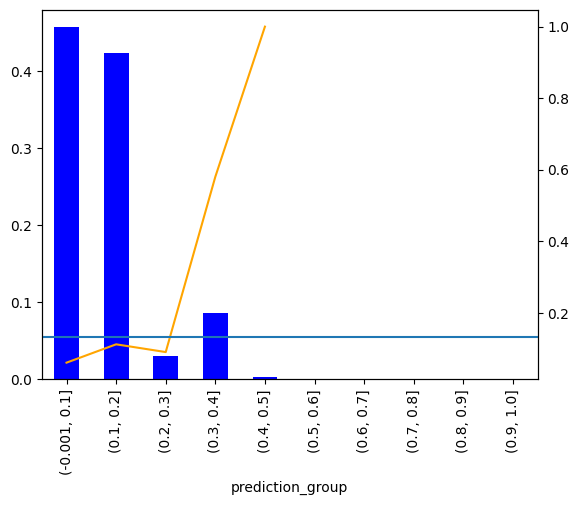

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       310
           1       0.00      0.00      0.00        47

    accuracy                           0.87       357
   macro avg       0.43      0.50      0.46       357
weighted avg       0.75      0.87      0.81       357

AUC Score: 0.6951956074124914


C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [37]:
present_scores(y_test, y_pred_proba, n_bins=10)

# Compute confusion matrix

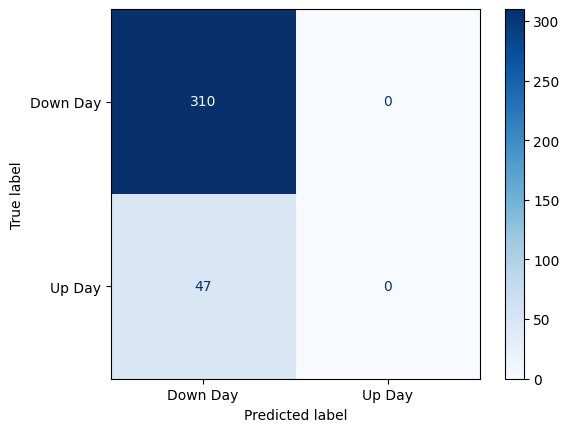

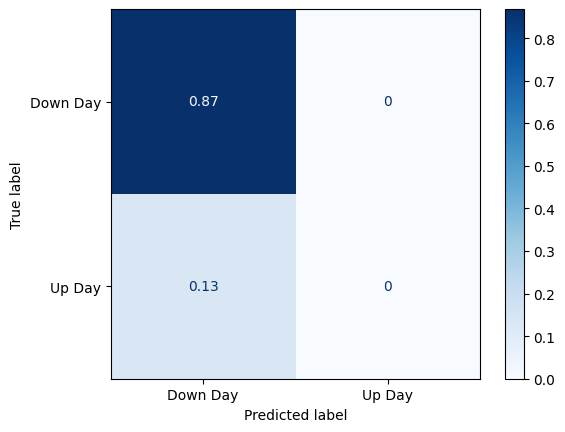

In [40]:
# Compute confusion matrix to evaluate the accuracy of the classification - displaying actual total values numbers per category

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Compute confusion matrix to evaluate the accuracy of the classification - displaying normalized values numbers

cm = confusion_matrix(y_test, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()



In [ ]:

# הבר (המקל) הכחול מתאר כמה תצפיות יש בכל בין של הסתברות, למשל, בבין של 0.3 עד 0.4 יש 38% מהתצפיות
# הקו הכחול לעומתו, מתאר את המציאות - כמה ״1״-ים יש לנו במציאות
# הקו הכתום, תמיד צריך להיות משווה לקו הכחול, מעיד על אחוז הדיוק בבין
# נשים את הסף כל עוד הקו הכתום מעל הקו הכחול, או במינימום בנק׳ המפגש שלהם
# במודל טוב - ככל שההתסברות גבוהה יותר, כך הוא גם צודק יותר, ולכן בגדול הקו הכתום צריך לעלות, אבל זה לא המצב אצלנו

In [39]:
#create the profit function - based on the percentage of change in the "market cap percentage" column

# create prediction column in the "test" dataframe based on the model results, set it to binary number instead of True / False

test['prediction'] = y_pred.astype(int)
# test = test.reset_index()
test['profit_percentage'] = test['diff_in_mc_perc'] * test['prediction']
profit_perc_sum = round(test['profit_percentage'].sum(), 3)
profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)

print("The total profit in percentage after investing in Google stock is:",profit_perc_mean,"%")

The total profit in percentage after investing in Google stock is: nan %


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_19260\2978561157.py:9: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)
